# Step 3: Exploratory Data Analysis

It is here that we want to look into various attributes of our data. The insights gained here will be very useful in defining how we train our models, our data distributions, and feature value/correlation to eachother and the target.

The primary points of interest are:
1) Feature correlation
2) Feature statistical distributions
3) Additional outlier detection
3) Any further insights that may drive feature engineering

---

In [21]:
import pandas as pd
import numpy as np
import csv
from copy import copy
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
import plotly.express as px
import seaborn as sns
from scipy.stats import ks_2samp, zscore

pd.options.display.max_columns = None

In [22]:
'''
Build helper functions for code cleanliness
'''

def outliers_Z_Score(sortedList: pd.DataFrame, outlierBoolean: list, outlierColumn: str, groupbyColumn: str, bound: float=[-1,1]):
    '''
    Identify outliers in column data when grouped by another column. Outlier detection uses Z-Score.
    Setting upper and lower bounds by 'n' standard deviations from mean where |n| > 0. Does not have to be symmetric.

    ## Parameters:
    - sortedList: Input dataframe
    - outlierBoolean: List of current ouliers from previous calls. If empty, will be initialized.
    - outlierColumn: Column name for outlier detection.
    - groupbyColumn: Column name for outliers to be grouped by.
    - bound: 1x2 array containing upper and lower bounds. bound=[lwr, upr].

    ## Returns:
    - outlierBoolean: pd.Series of 1(True)/0(False) based on outlierColumn and groupbyColumn selected.
    '''
    if any(outlierBoolean)==False:
        outlierBoolean = [0] * sortedList.shape[0]

    for item in sortedList[groupbyColumn].unique():
        itemIndex = sortedList.index[sortedList[groupbyColumn]==item]
        score = zscore(np.array(sortedList[outlierColumn].loc[sortedList[groupbyColumn]==item]))
        for i, TF in enumerate(itemIndex):
            if score[i] < bound[0] or score[i] > bound[1]:
                outlierBoolean[TF] = 1
    return np.array(outlierBoolean)

In [23]:
'''
Read in csv files.
'''

df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold.drop(columns=['dateSold'], inplace=True)

# Feature Correlations

---

<function matplotlib.pyplot.show(close=None, block=None)>

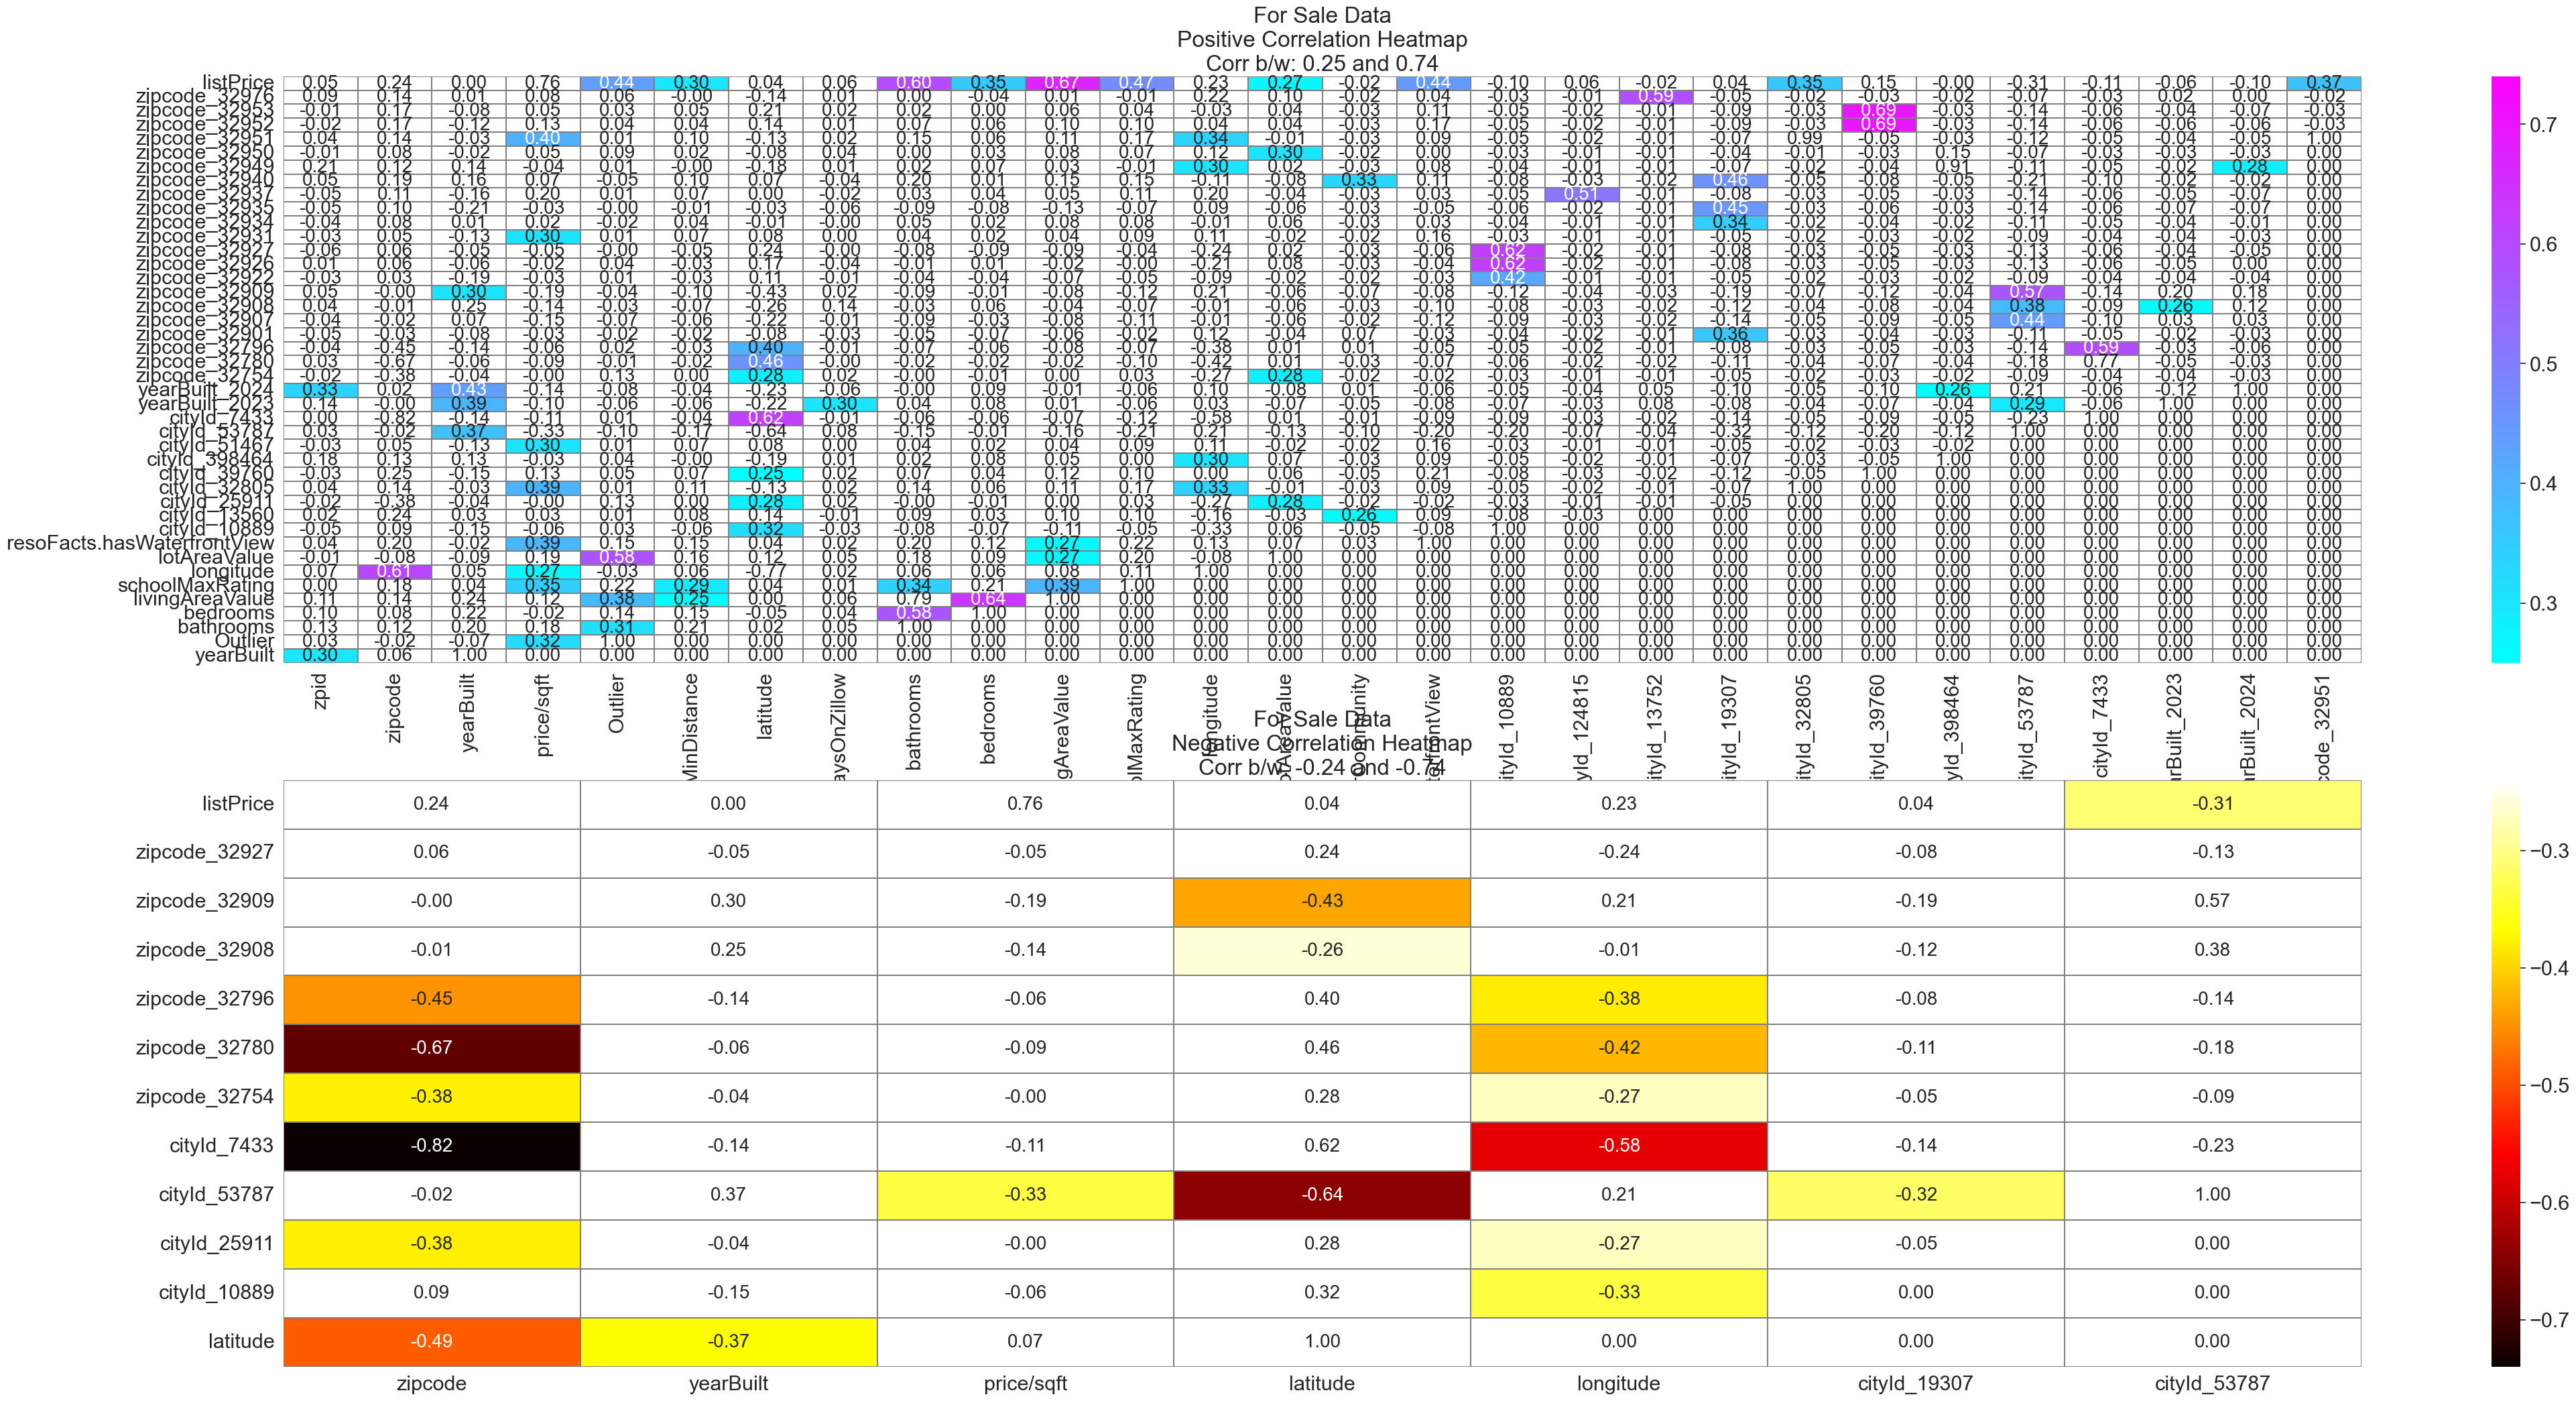

In [25]:
'''
Correlation heatmaps
'''

correlatedFeat2Remove = ['zestimate', 'cityId_398464.0', 'cityId_13560.0', 'cityId_14563.0', 'cityId_20367.0', 'cityId_46375.0', 'cityId_7433.0']

# Remove move one from each pair that is within these values.
# Too strong of a correlation to price could lead to overfitting.
#Too strong of a correlation to another feature is an indication of multicolliniarity.
val_min = [0.75, -0.99]
val_max = [0.99, -0.75]

# These values highlight features that could be great candidates for model training.
# Not too strongly correlated to target or eachother.
val_min = [0.25, -0.74]
val_max = [0.74, -0.24]

updatedCols = [col not in correlatedFeat2Remove for col in df_forSale.columns]
corr = df_forSale.loc[:,updatedCols].corr().to_numpy()
labels = df_forSale.loc[:,updatedCols].columns


fig, ax = plt.subplots(2,1,figsize=(50,25))
sns.set_theme(font_scale=2.0)
my_cmap = copy(plt.cm.cool)
my_cmap.set_over('white')
my_cmap.set_under('white')

corr = np.tril(corr)
ind_x, = np.where(np.all(np.logical_or(corr<val_min[0], corr>val_max[0]), axis=0))
corr = np.delete(corr, ind_x, 1)
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]

ind_y, = np.where(np.all(np.logical_or(corr<val_min[0], corr>val_max[0]), axis=1))
corr = np.delete(corr, ind_y, 0)
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

p1 = sns.heatmap(corr,
                 xticklabels=map_labels_x,
                 yticklabels=map_labels_y,
                 vmin=val_min[0],
                 vmax=val_max[0],
                 annot=True,
                 annot_kws={'size':20},
                 fmt='.2f',
                 cmap=my_cmap,
                 linewidth=0.1,
                 linecolor='grey',
                 ax=ax[0])

p1.set_title(f'For Sale Data\nPositive Correlation Heatmap\nCorr b/w: {val_min[0]} and {val_max[0]}')
p1.set_xlim(0, len(map_labels_x))
p1.set_ylim(0, len(map_labels_y))

my_cmap = copy(plt.cm.hot)
corr = df_forSale.loc[:,updatedCols].corr().to_numpy()
corr = np.tril(corr)
ind_x, = np.where(np.all(np.logical_or(corr<val_min[1], corr>val_max[1]), axis=0))
corr = np.delete(corr, ind_x, 1)
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]

ind_y, = np.where(np.all(np.logical_or(corr<val_min[1], corr>val_max[1]), axis=1))
corr = np.delete(corr, ind_y, 0)
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

p2 = sns.heatmap(corr,
                 xticklabels=map_labels_x,
                 yticklabels=map_labels_y,
                 vmin=val_min[1],
                 vmax=val_max[1],
                 annot=True,
                 annot_kws={'size':20},
                 fmt='.2f',
                 cmap=my_cmap,
                 linewidth=0.1,
                 linecolor='grey',
                 ax=ax[1])

p2.set_title(f'For Sale Data\nNegative Correlation Heatmap\nCorr b/w: {val_max[1]} and {val_min[1]}')
p2.set_xlim(0, len(map_labels_x))
p2.set_ylim(0, len(map_labels_y))

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

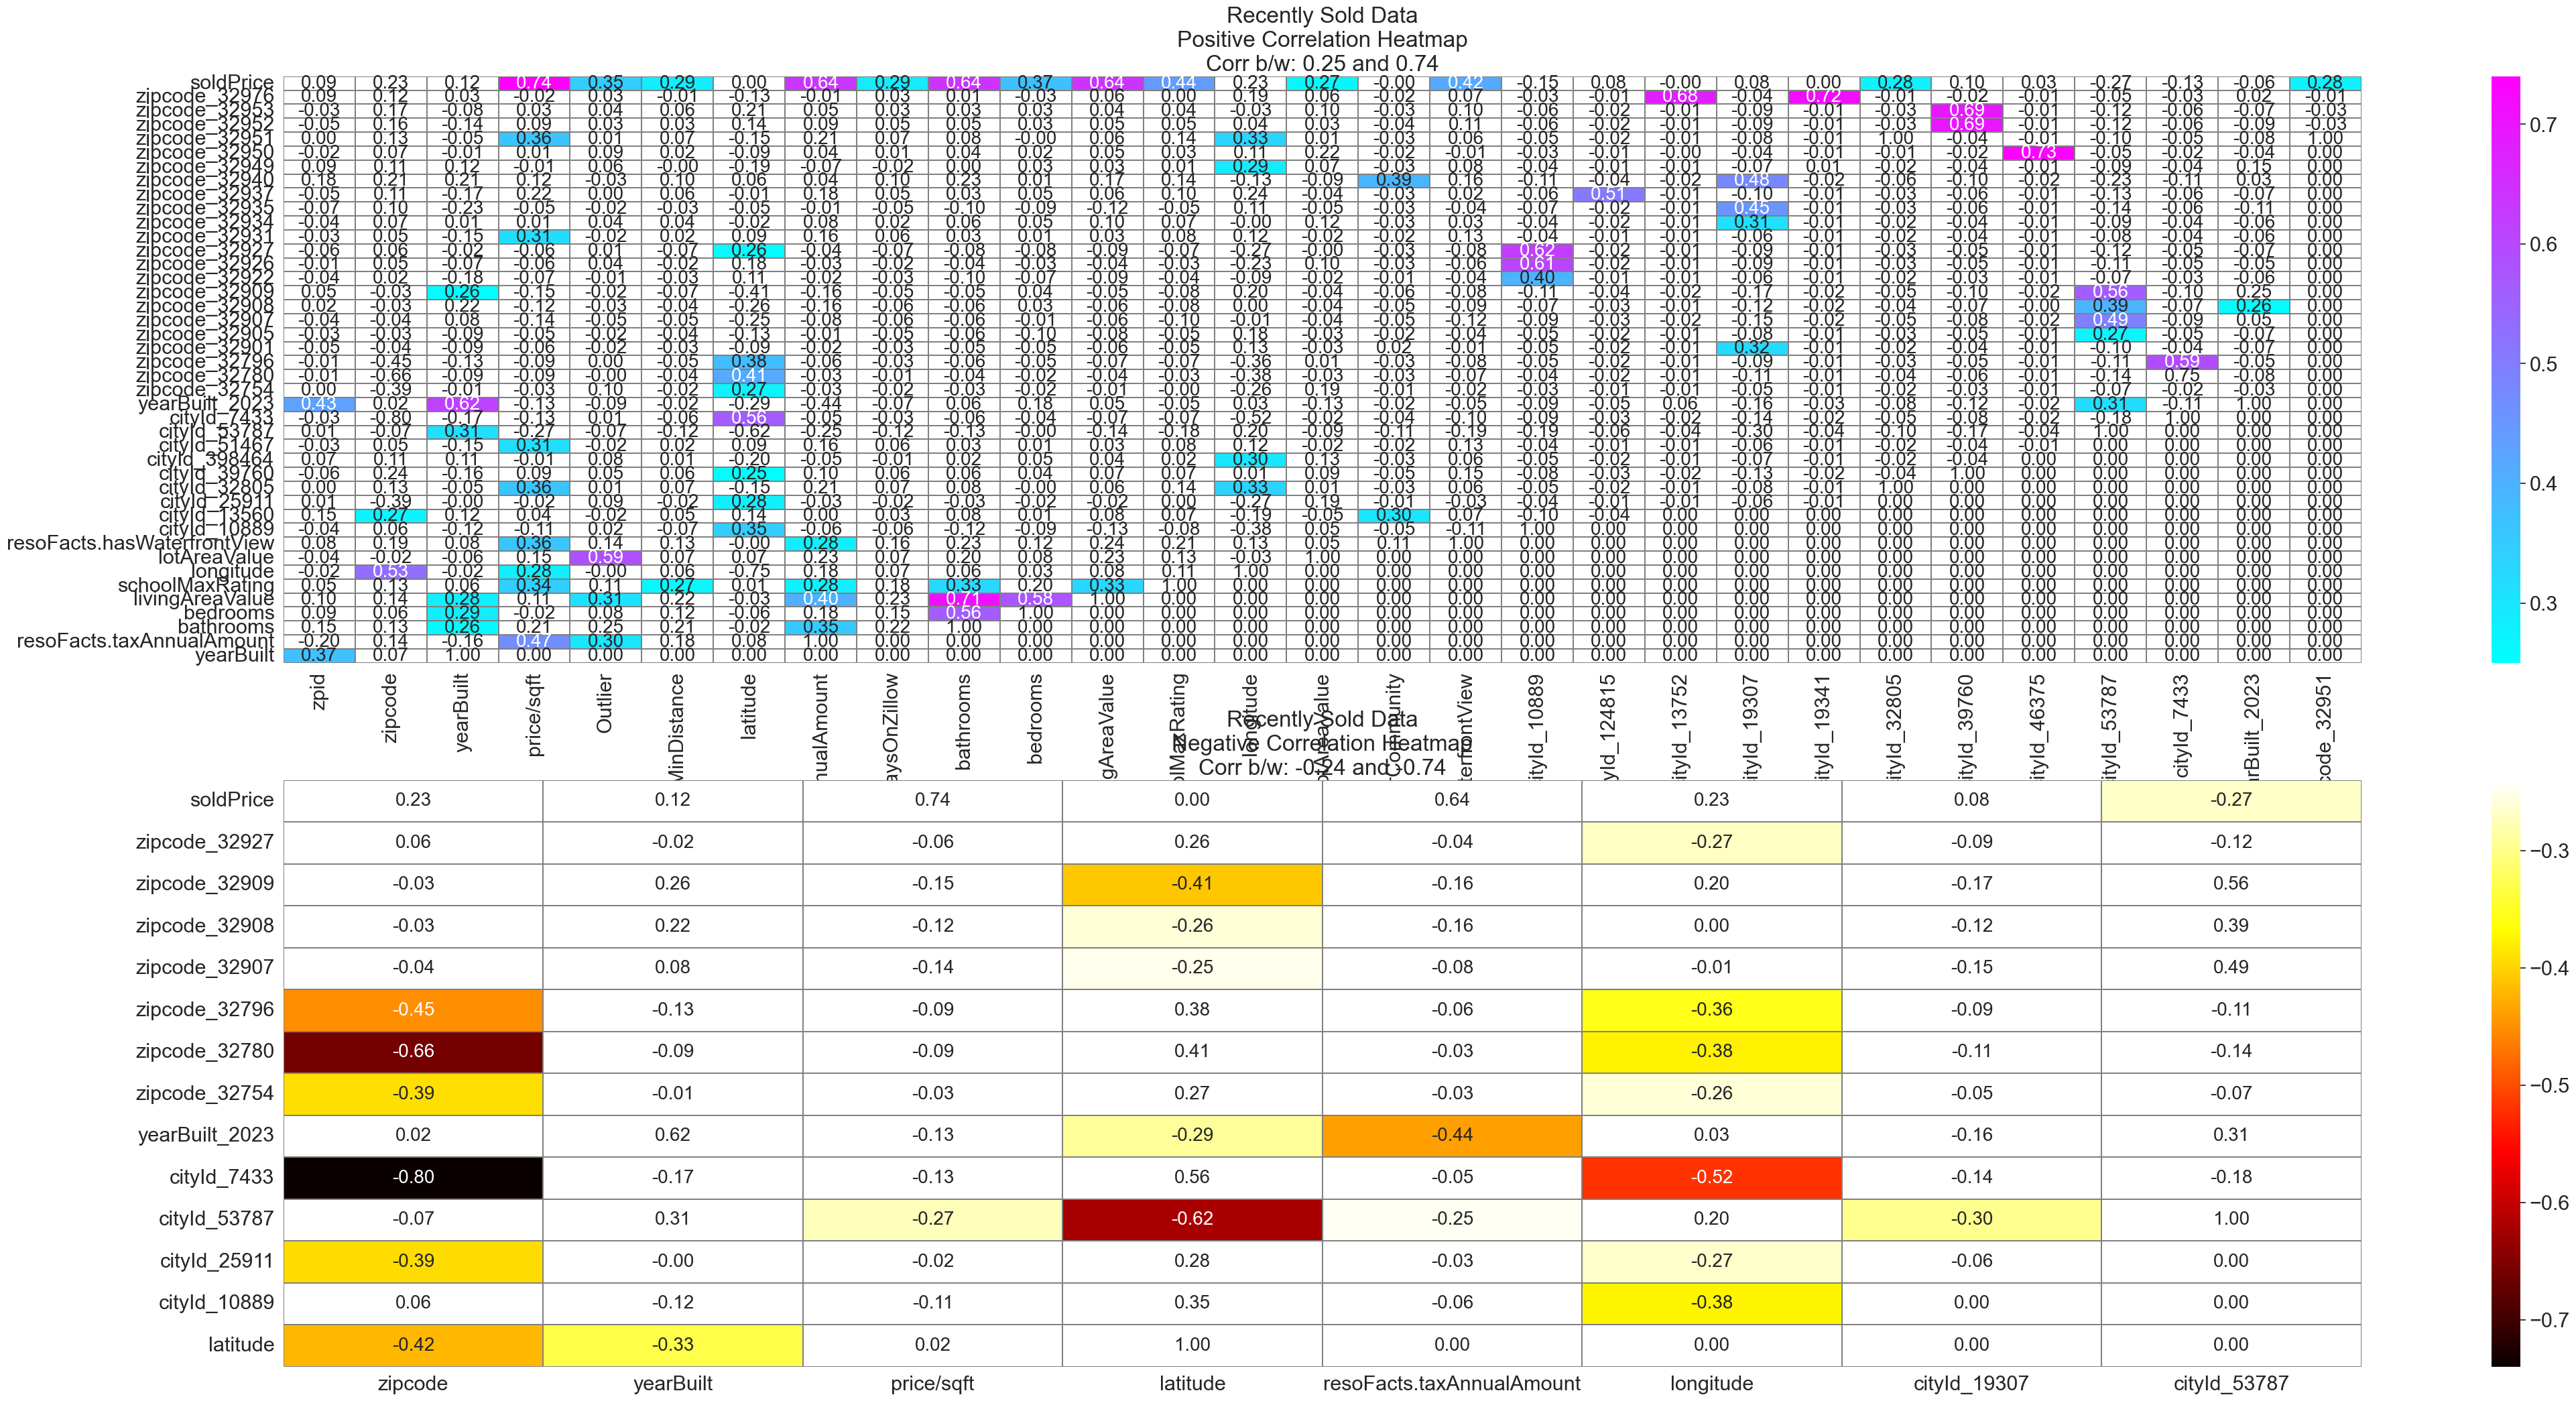

In [5]:
'''
Correlation heatmaps
'''

correlatedFeat2Remove = ['zestimate', 'cityId_25911.0', 'listPrice', 'cityId_398464.0', 'cityId_14563.0', 'cityId_20367.0', 'cityId_52625.0', 'cityId_7433.0']

updatedCols = [col not in correlatedFeat2Remove for col in df_recentlySold.columns]
corr = df_recentlySold.loc[:,updatedCols].corr().to_numpy()
labels = df_recentlySold.loc[:,updatedCols].columns


fig, ax = plt.subplots(2,1,figsize=(50,25))
sns.set_theme(font_scale=2.0)
my_cmap = copy(plt.cm.cool)
my_cmap.set_over('white')
my_cmap.set_under('white')

corr = np.tril(corr)
ind_x, = np.where(np.all(np.logical_or(corr<val_min[0], corr>val_max[0]), axis=0))
corr = np.delete(corr, ind_x, 1)
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]

ind_y, = np.where(np.all(np.logical_or(corr<val_min[0], corr>val_max[0]), axis=1))
corr = np.delete(corr, ind_y, 0)
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

p1 = sns.heatmap(corr,
                 xticklabels=map_labels_x,
                 yticklabels=map_labels_y,
                 vmin=val_min[0],
                 vmax=val_max[0],
                 annot=True,
                 annot_kws={'size':20},
                 fmt='.2f',
                 cmap=my_cmap,
                 linewidth=0.1,
                 linecolor='grey',
                 ax=ax[0])

p1.set_title(f'Recently Sold Data\nPositive Correlation Heatmap\nCorr b/w: {val_min[0]} and {val_max[0]}')
p1.set_xlim(0, len(map_labels_x))
p1.set_ylim(0, len(map_labels_y))

my_cmap = copy(plt.cm.hot)
corr = df_recentlySold.loc[:,updatedCols].corr().to_numpy()
corr = np.tril(corr)
ind_x, = np.where(np.all(np.logical_or(corr<val_min[1], corr>val_max[1]), axis=0))
corr = np.delete(corr, ind_x, 1)
map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]

ind_y, = np.where(np.all(np.logical_or(corr<val_min[1], corr>val_max[1]), axis=1))
corr = np.delete(corr, ind_y, 0)
map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

p2 = sns.heatmap(corr,
                 xticklabels=map_labels_x,
                 yticklabels=map_labels_y,
                 vmin=val_min[1],
                 vmax=val_max[1],
                 annot=True,
                 annot_kws={'size':20},
                 fmt='.2f',
                 cmap=my_cmap,
                 linewidth=0.1,
                 linecolor='grey',
                 ax=ax[1])

p2.set_title(f'Recently Sold Data\nNegative Correlation Heatmap\nCorr b/w: {val_max[1]} and {val_min[1]}')
p2.set_xlim(0, len(map_labels_x))
p2.set_ylim(0, len(map_labels_y))

plt.show

# Feature Histograms and Statistical Distributions

---

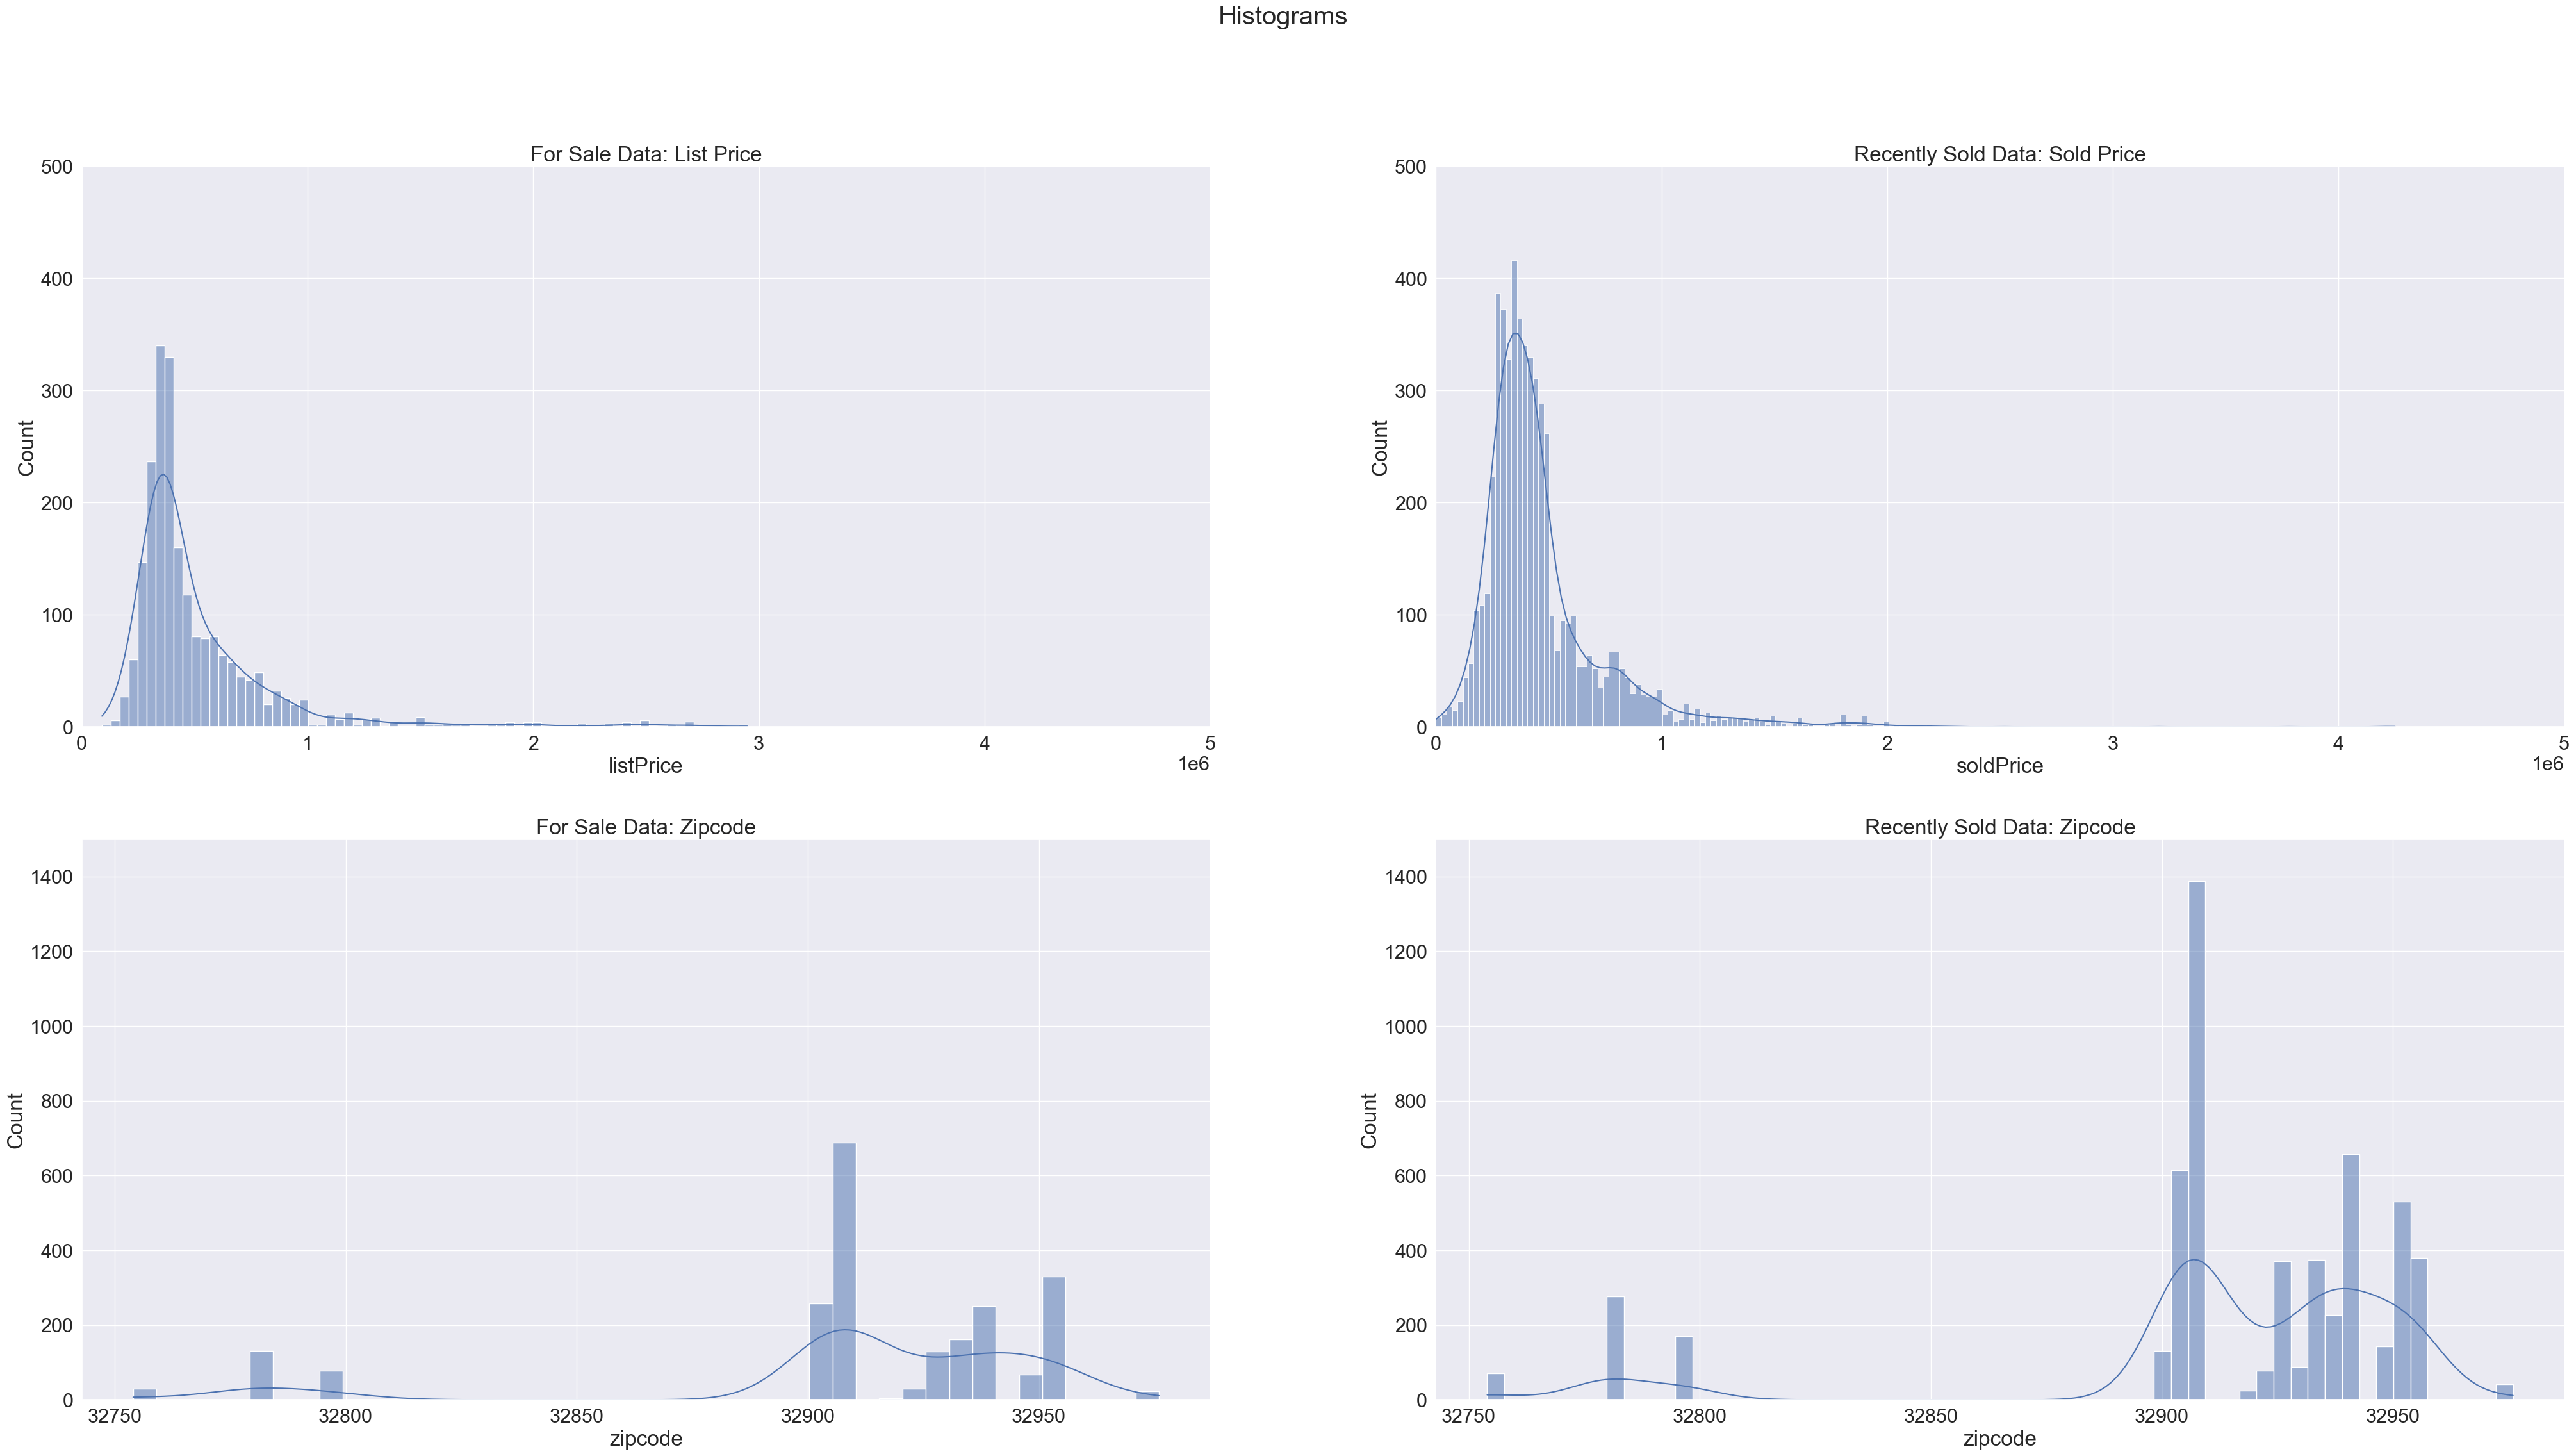

In [6]:
'''
Histograms
'''

pairPlotFeatures = ['bathrooms','listPrice','price/sqft','zipcode','livingAreaValue']
updatedCols = [col in pairPlotFeatures for col in df_forSale.columns]
pair_forSale = df_forSale.loc[:,updatedCols].copy()

pairPlotFeatures = ['bathrooms','soldPrice','price/sqft','zipcode','livingAreaValue']
updatedCols = [col in pairPlotFeatures for col in df_recentlySold.columns]
pair_recentlySold = df_recentlySold.loc[:,updatedCols].copy()


fig, ax = plt.subplots(2,2,figsize=(50,25))
plt.setp(ax[0,0], xlim=[0, 5e6], ylim=[0, 500])
plt.setp(ax[0,1], xlim=[0, 5e6], ylim=[0, 500])
plt.setp(ax[1,0], ylim=[0, 1500])
plt.setp(ax[1,1], ylim=[0, 1500])
plt.suptitle('Histograms')

sns.histplot(pair_forSale['listPrice'], kde=True, ax=ax[0,0])
ax[0,0].title.set_text('For Sale Data: List Price')

sns.histplot(pair_recentlySold['soldPrice'], kde=True, ax=ax[0,1])
ax[0,1].title.set_text('Recently Sold Data: Sold Price')

sns.histplot(pair_forSale['zipcode'], kde=True, ax=ax[1,0])
ax[1,0].title.set_text('For Sale Data: Zipcode')

sns.histplot(pair_recentlySold['zipcode'], kde=True, ax=ax[1,1])
ax[1,1].title.set_text('Recently Sold Data: Zipcode')

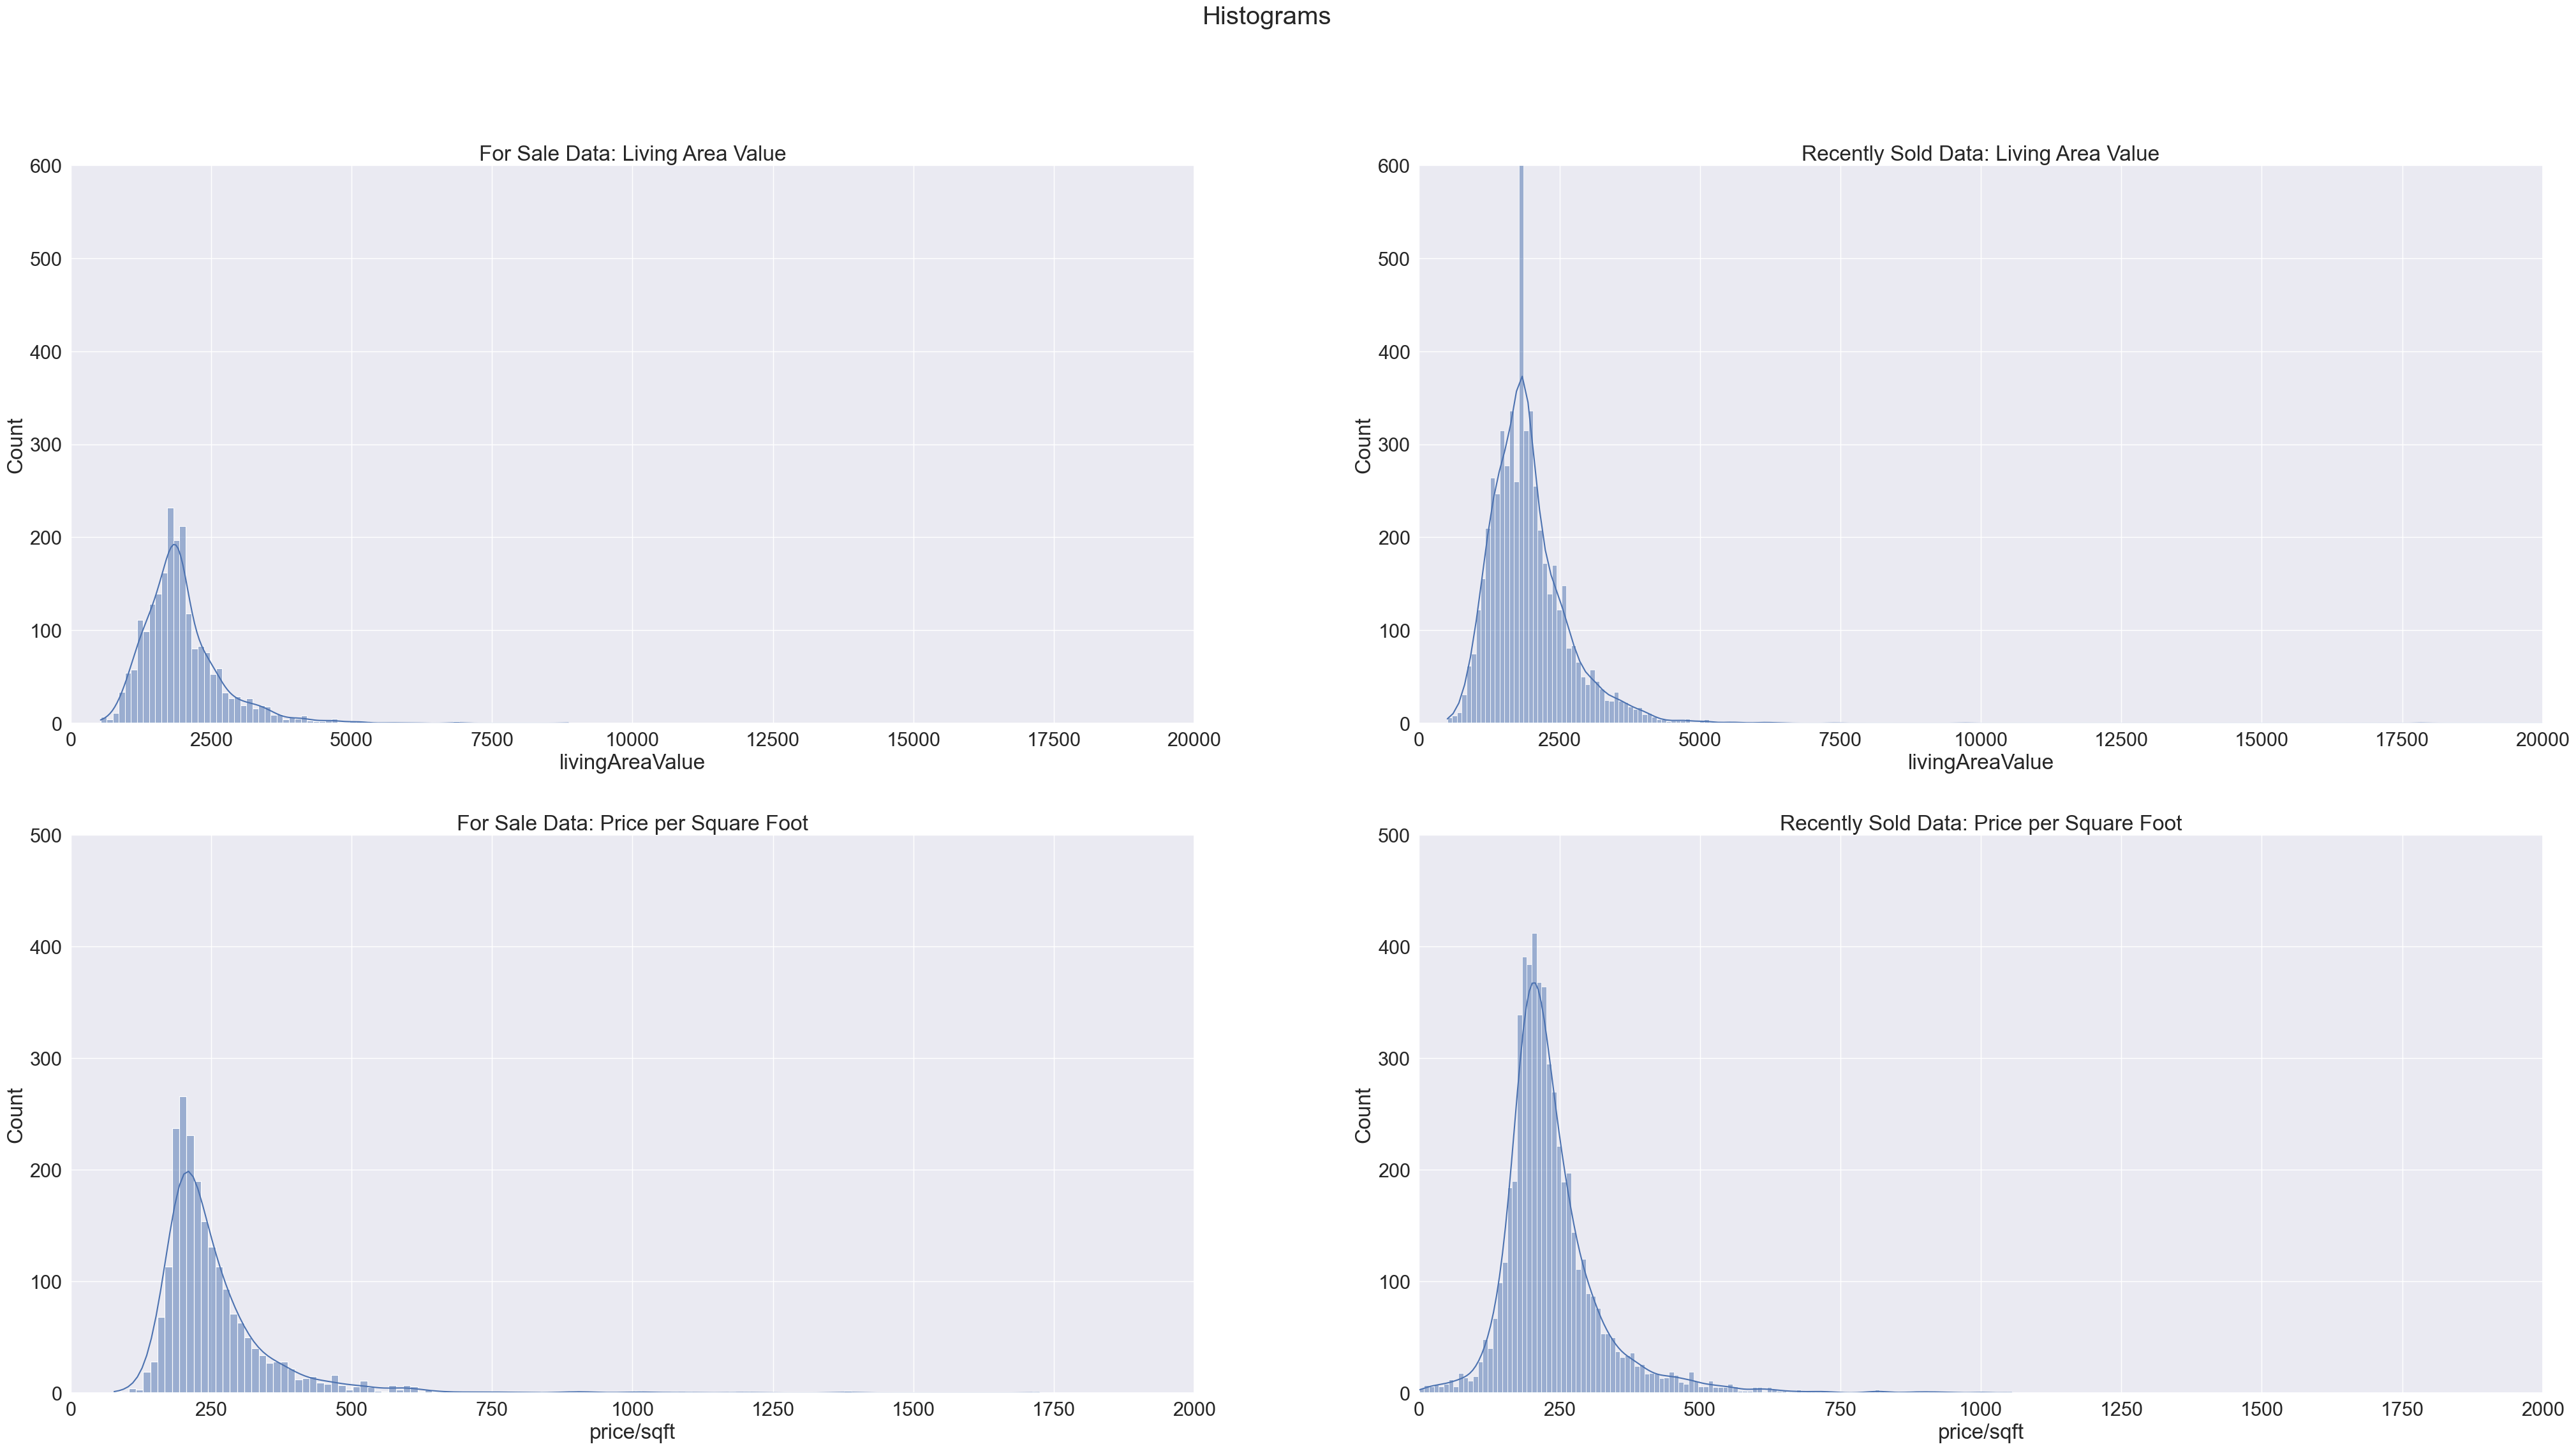

In [7]:
'''
Histograms
'''

pairPlotFeatures = ['bathrooms','listPrice','price/sqft','zipcode','livingAreaValue']
updatedCols = [col in pairPlotFeatures for col in df_forSale.columns]
pair_forSale = df_forSale.loc[:,updatedCols].copy()

pairPlotFeatures = ['bathrooms','soldPrice','price/sqft','zipcode','livingAreaValue']
updatedCols = [col in pairPlotFeatures for col in df_recentlySold.columns]
pair_recentlySold = df_recentlySold.loc[:,updatedCols].copy()


fig, ax = plt.subplots(2,2,figsize=(50,25))
plt.setp(ax[0,0], xlim=[0, 20000], ylim=[0, 600])
plt.setp(ax[0,1], xlim=[0, 20000], ylim=[0, 600])
plt.setp(ax[1,0], xlim=[0, 2000], ylim=[0, 500])
plt.setp(ax[1,1], xlim=[0, 2000], ylim=[0, 500])
plt.suptitle('Histograms')

sns.histplot(pair_forSale['livingAreaValue'], kde=True, ax=ax[0,0])
ax[0,0].title.set_text('For Sale Data: Living Area Value')

sns.histplot(pair_recentlySold['livingAreaValue'], kde=True, ax=ax[0,1])
ax[0,1].title.set_text('Recently Sold Data: Living Area Value')

sns.histplot(pair_forSale['price/sqft'], kde=True, ax=ax[1,0])
ax[1,0].title.set_text('For Sale Data: Price per Square Foot')

sns.histplot(pair_recentlySold['price/sqft'], kde=True, ax=ax[1,1])
ax[1,1].title.set_text('Recently Sold Data: Price per Square Foot')

In [8]:
'''
Checking feature distribution similarities using two-sample Kolmogorov-Smirnov fit of goodness
'''

yes = 0
no = 0
diff_Feats = []

print('ATTENTION: Make sure the two dataframes have the same number of features and are in the same order!')
print('')

for i in range(df_forSale.shape[1]):
    # Assuming 'data1' and 'data2' are your datasets
    statistic, p_value = ks_2samp(df_forSale.iloc[:, i].values, df_recentlySold.iloc[:, i].values)
    if p_value < 0.05:
        # print(f'Feature {df_forSale.columns[i]} is significantly different.')
        diff_Feats.append(df_forSale.columns[i])
        yes+=1
    else:
        # print(f'Feature {df_forSale.columns[i]} is NOT significantly different')
        no+=1

print(f'{yes} of {yes+no} ({round(yes/(yes+no)*100,2)}%) feature distributions are significantly different.')
if round(yes/(yes+no)*100,2) > 5:
    print('Recommend distribution matching!')
print('')
print(f'These are the features that differ:')
for feat in diff_Feats:
    print(feat)

ATTENTION: Make sure the two dataframes have the same number of features and are in the same order!

20 of 155 (12.9%) feature distributions are significantly different.
Recommend distribution matching!

These are the features that differ:
zpid
zipcode
yearBuilt
price/sqft
latitude
zestimate
resoFacts.taxAnnualAmount
resoFacts.garageSpaces
daysOnZillow
bedrooms
livingAreaValue
schoolMaxRating
longitude
lotAreaValue
cityId_53787
yearBuilt_2023
yearBuilt_2024
zipcode_32909
zipcode_32940
listPrice


# Check for Additional Outliers

---

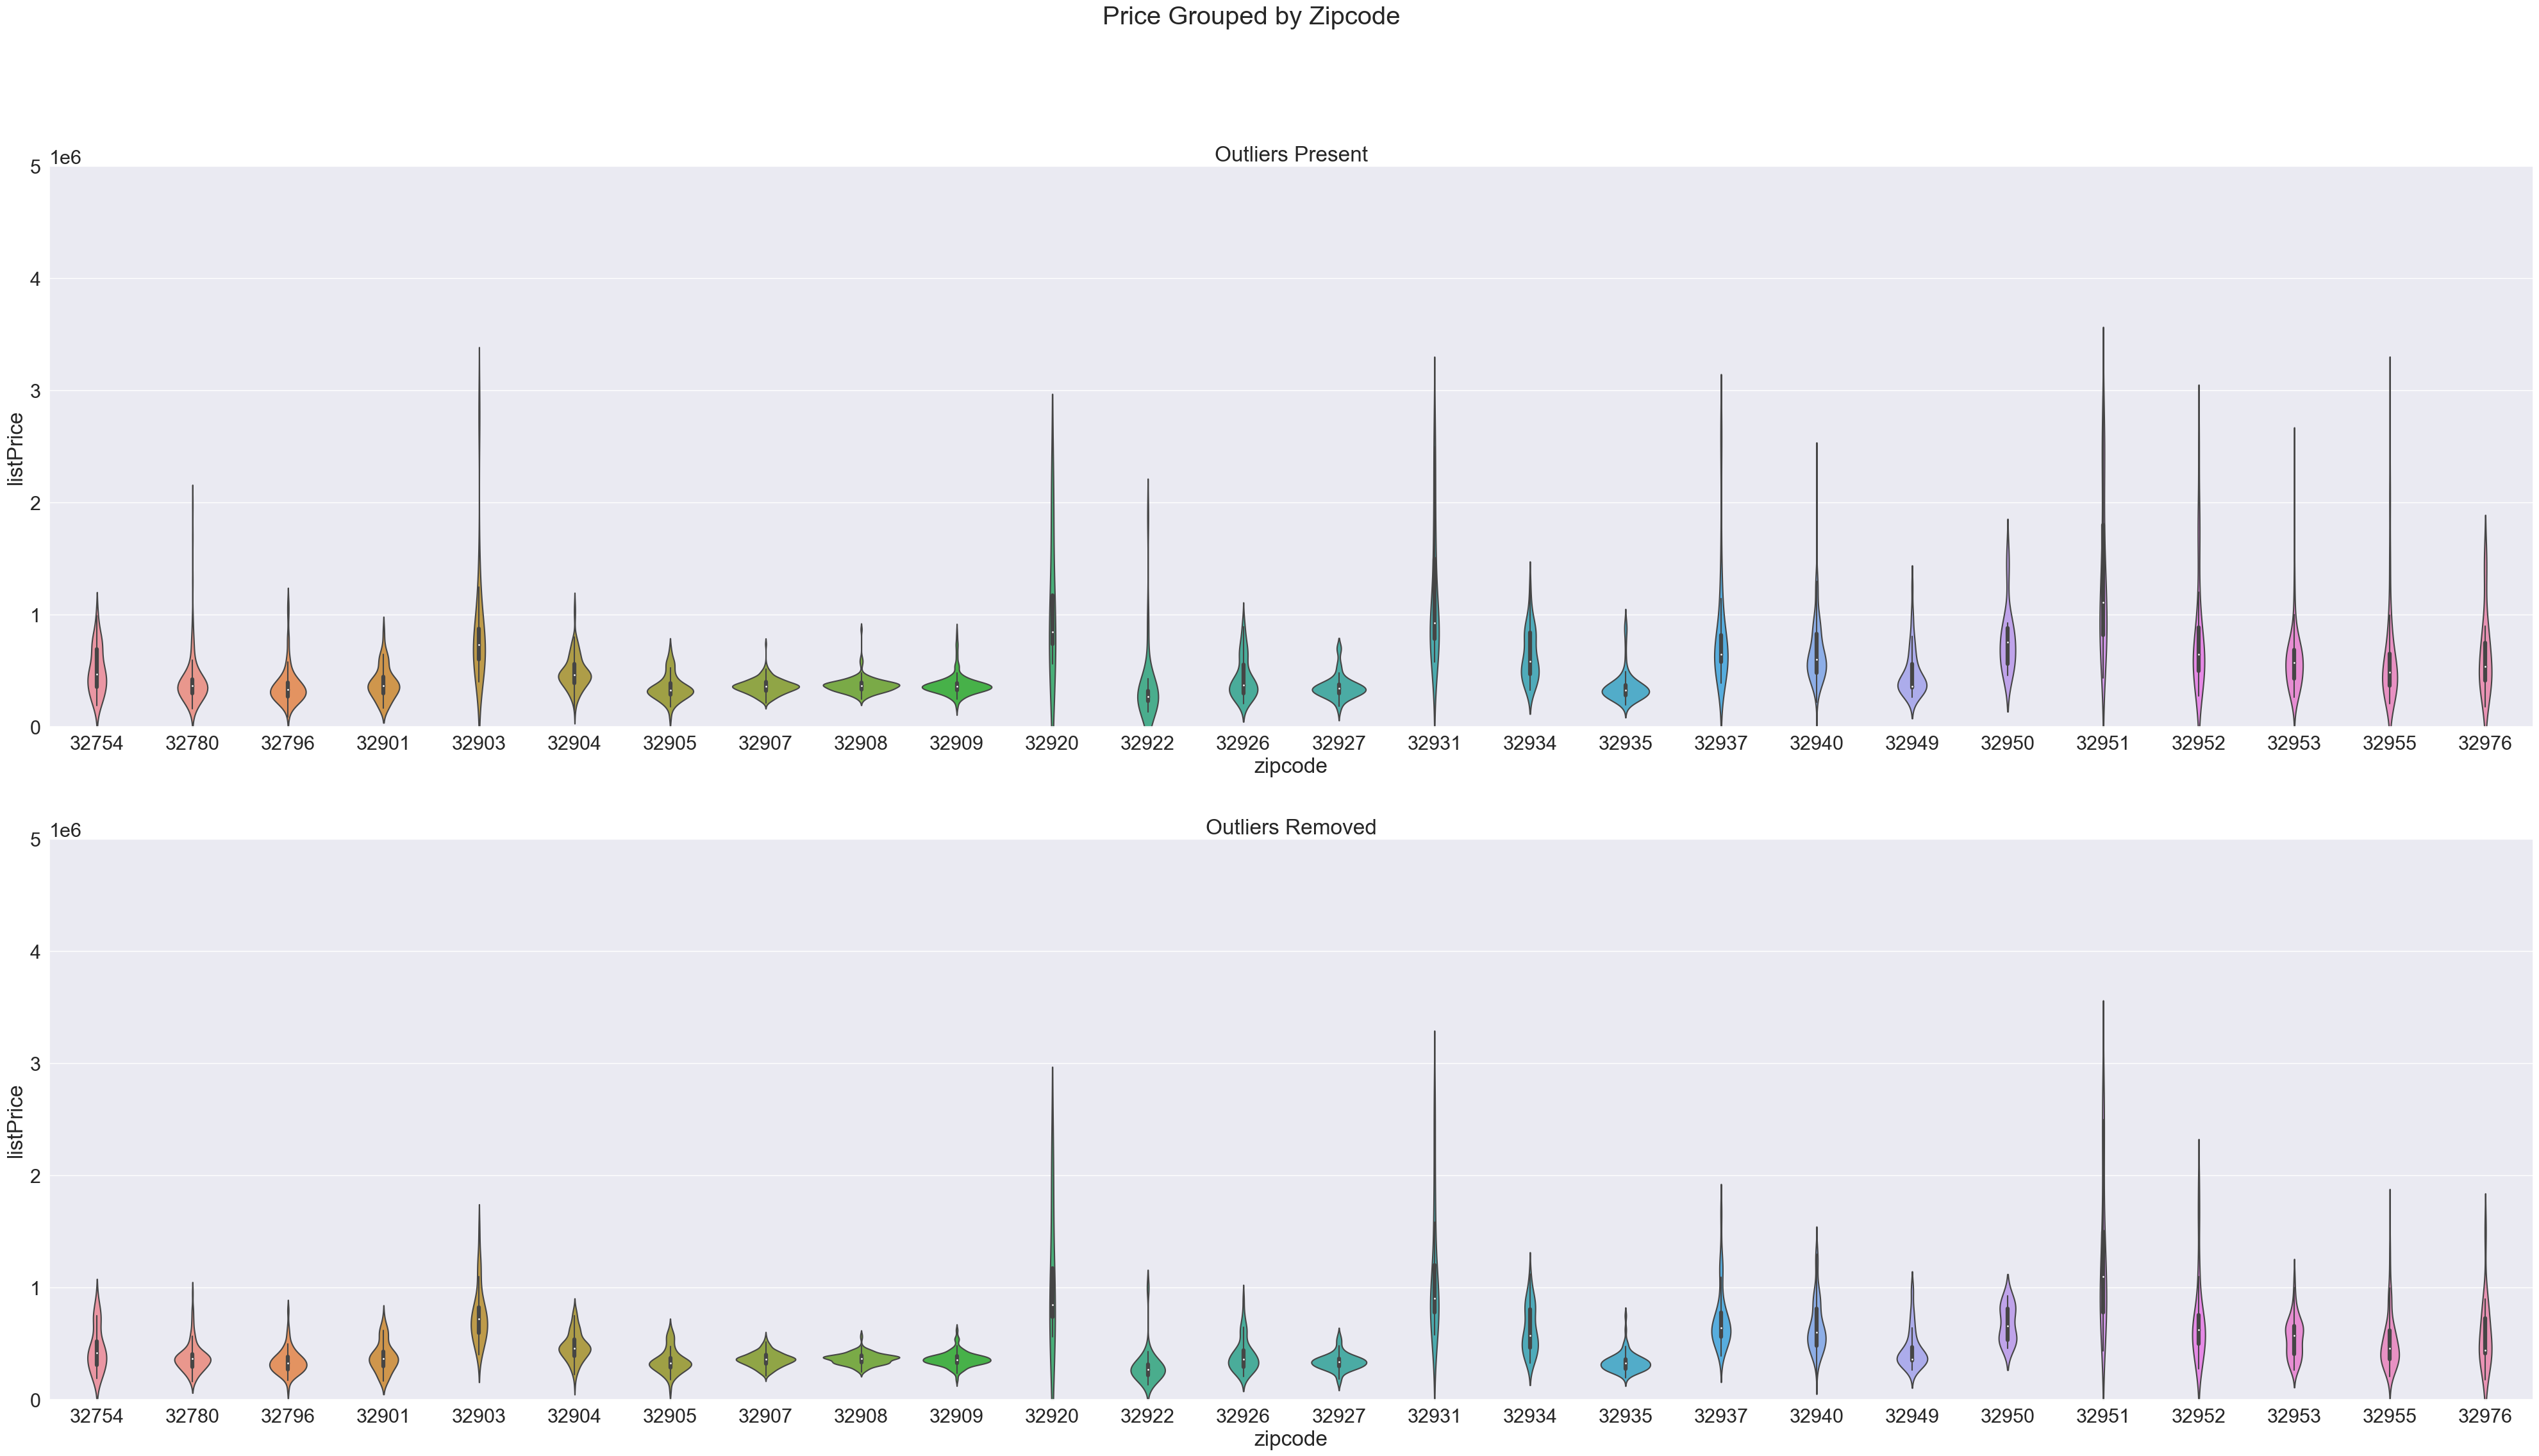

In [9]:
'''
Effect of outlier detection on price per zipcode during data wrangling
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))
sns.set_theme(font_scale=2.0)
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
plt.suptitle('Price Grouped by Zipcode')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale, ax=ax[0])
ax[0].title.set_text('Outliers Present')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale.loc[df_forSale['Outlier']==0], ax=ax[1])
ax[1].title.set_text('Outliers Removed')

plt.show()

What you can see above is that the initial price outlier removal process did a great job. There is, however, still some work to be done.

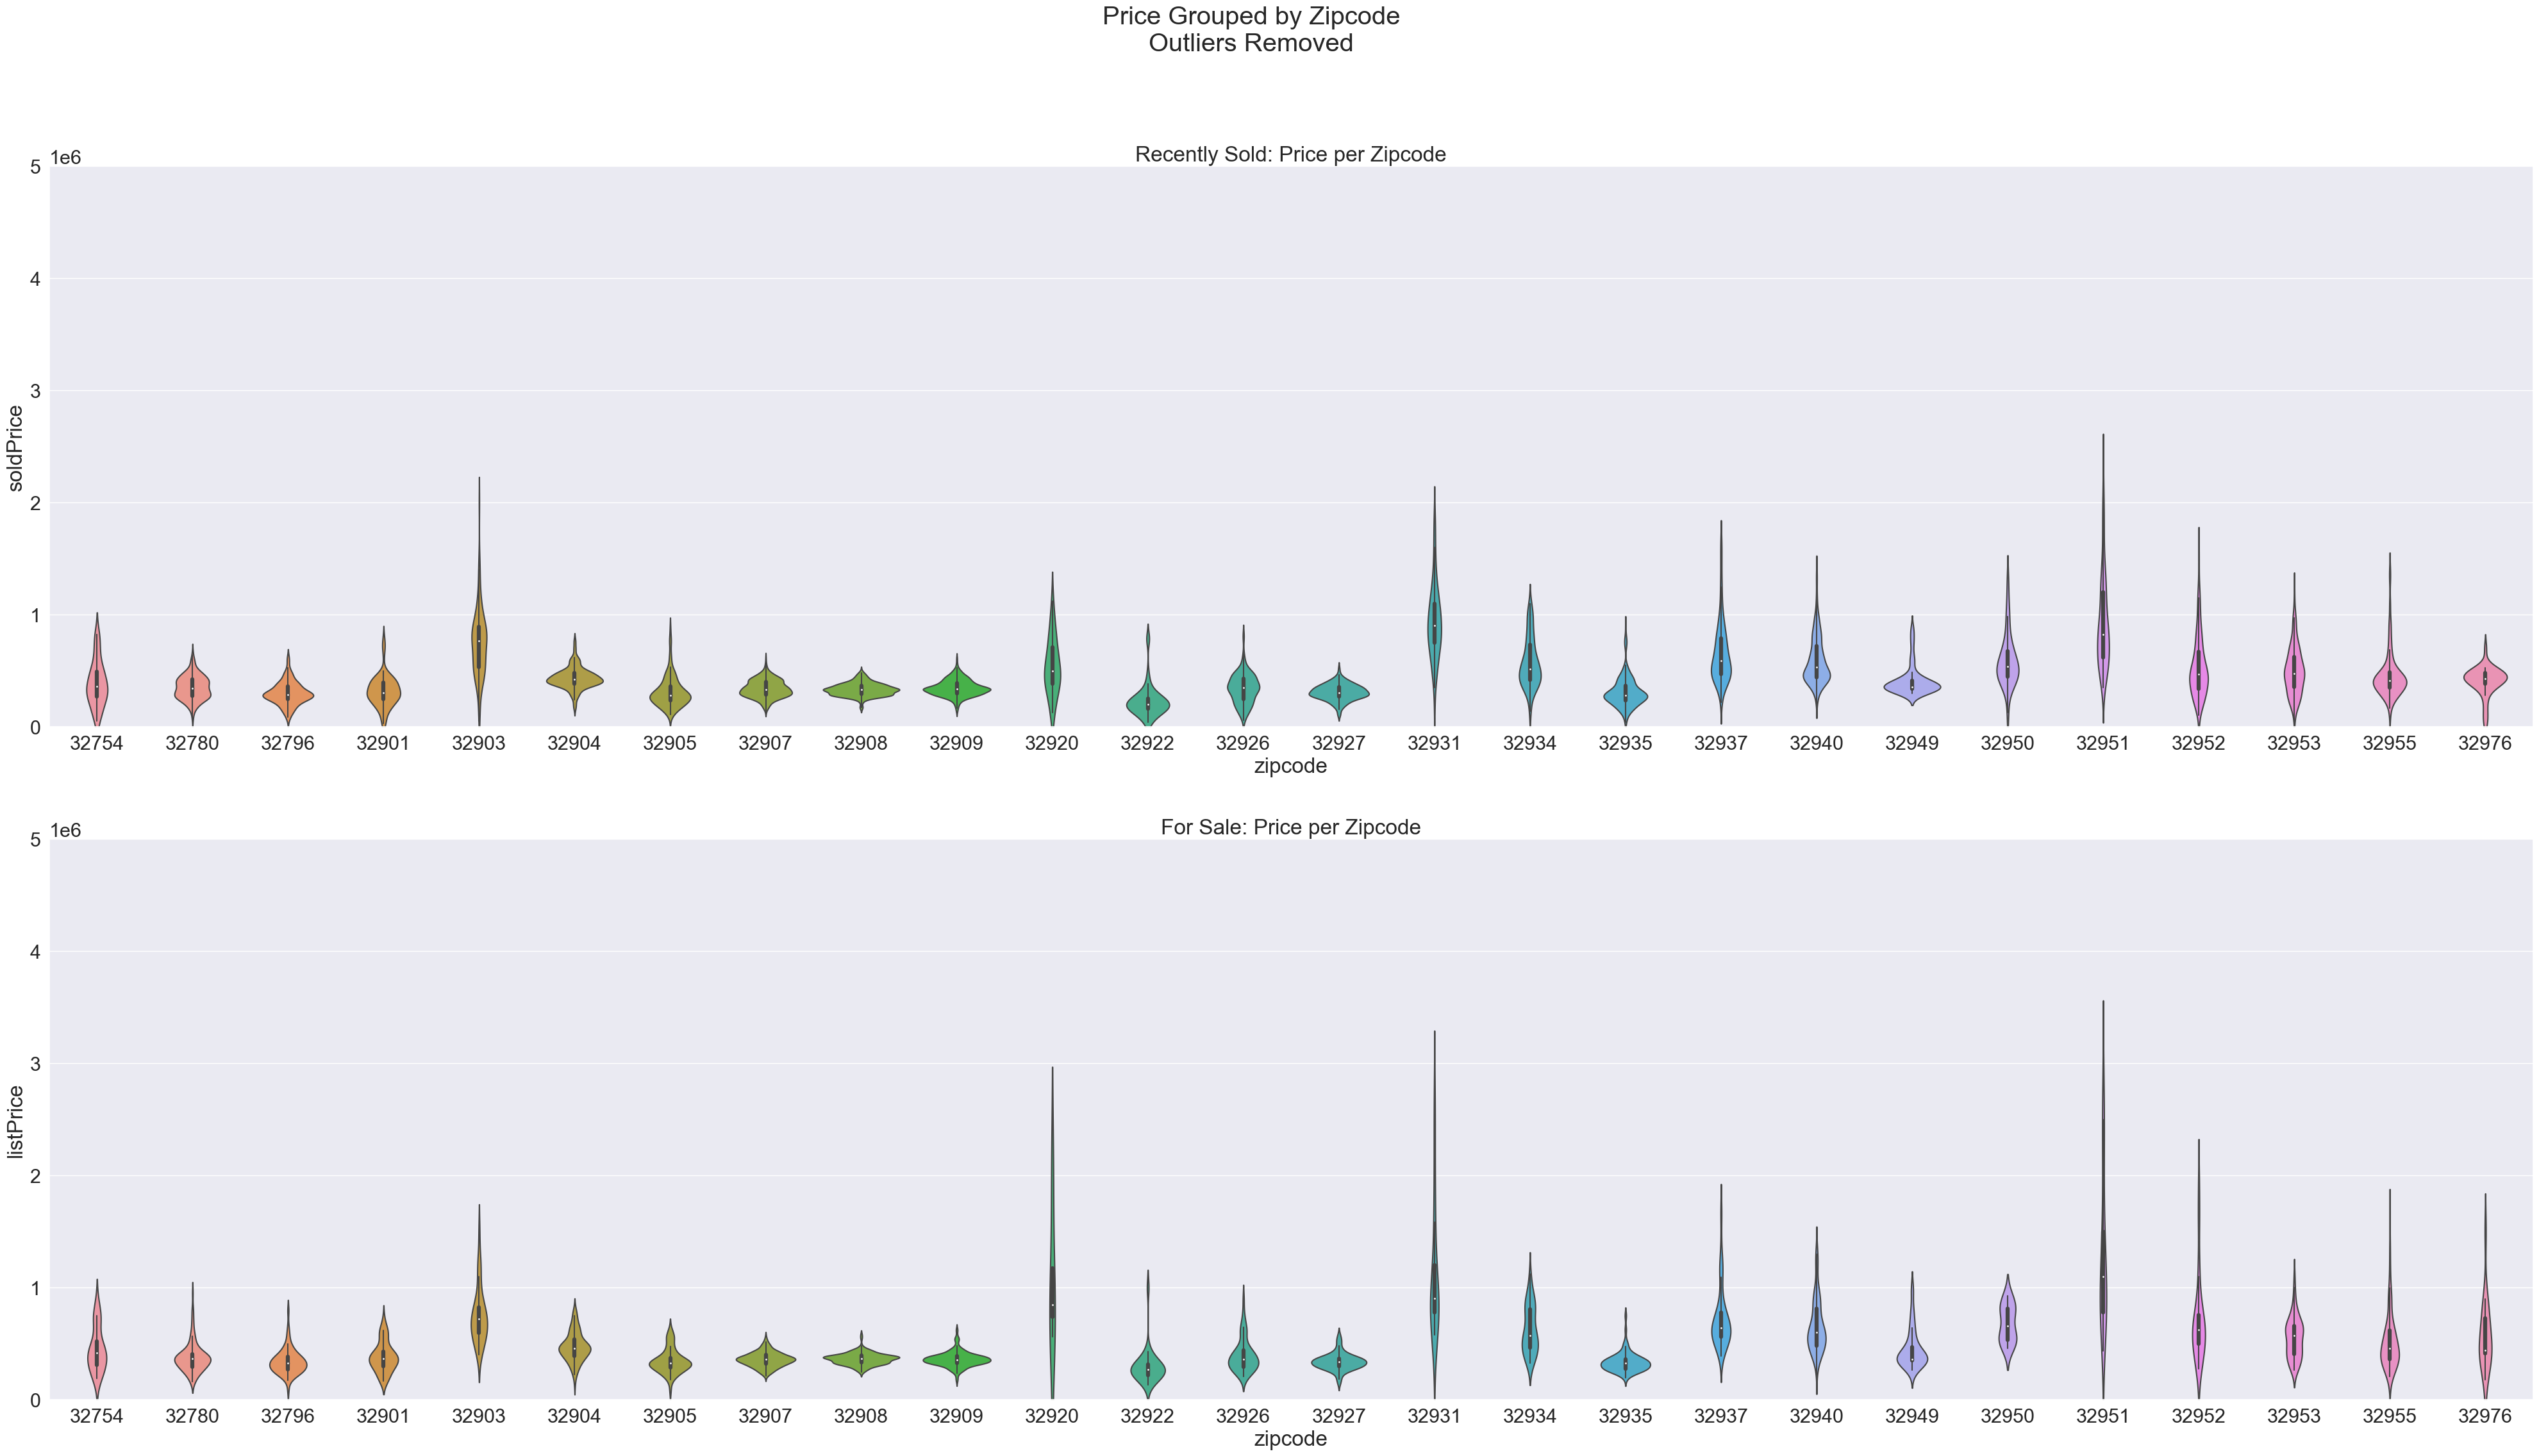

In [10]:
'''
Price distribution by zipcode - Initial outliers removed.
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))
sns.set_theme(font_scale=2.0)
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
plt.suptitle('Price Grouped by Zipcode\nOutliers Removed')

sns.violinplot(x='zipcode', y='soldPrice', data=df_recentlySold.loc[df_recentlySold['Outlier']==0], ax=ax[0])
ax[0].title.set_text('Recently Sold: Price per Zipcode')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale.loc[df_forSale['Outlier']==0], ax=ax[1])
ax[1].title.set_text('For Sale: Price per Zipcode')

plt.show()

In [11]:
'''
Compute Z-score for price when grouped by zipcode. This should be done on all samples.
Create a new column in each dataframe for Z-score.
'''

outlierBoolean_fs = []
outlierBoolean_rs = []

listPrice = df_forSale.sort_values(by='price/sqft').copy()
outlierBoolean_fs = outliers_Z_Score(sortedList=listPrice, outlierBoolean=outlierBoolean_fs, outlierColumn='price/sqft', groupbyColumn='zipcode')

soldPrice = df_recentlySold.sort_values(by='price/sqft').copy()
outlierBoolean_rs = outliers_Z_Score(sortedList=soldPrice, outlierBoolean=outlierBoolean_rs, outlierColumn='price/sqft', groupbyColumn='zipcode')

df_forSale.insert(9, 'Outlier: Z-Score', outlierBoolean_fs, True)
df_recentlySold.insert(9, 'Outlier: Z-Score', outlierBoolean_rs, True)

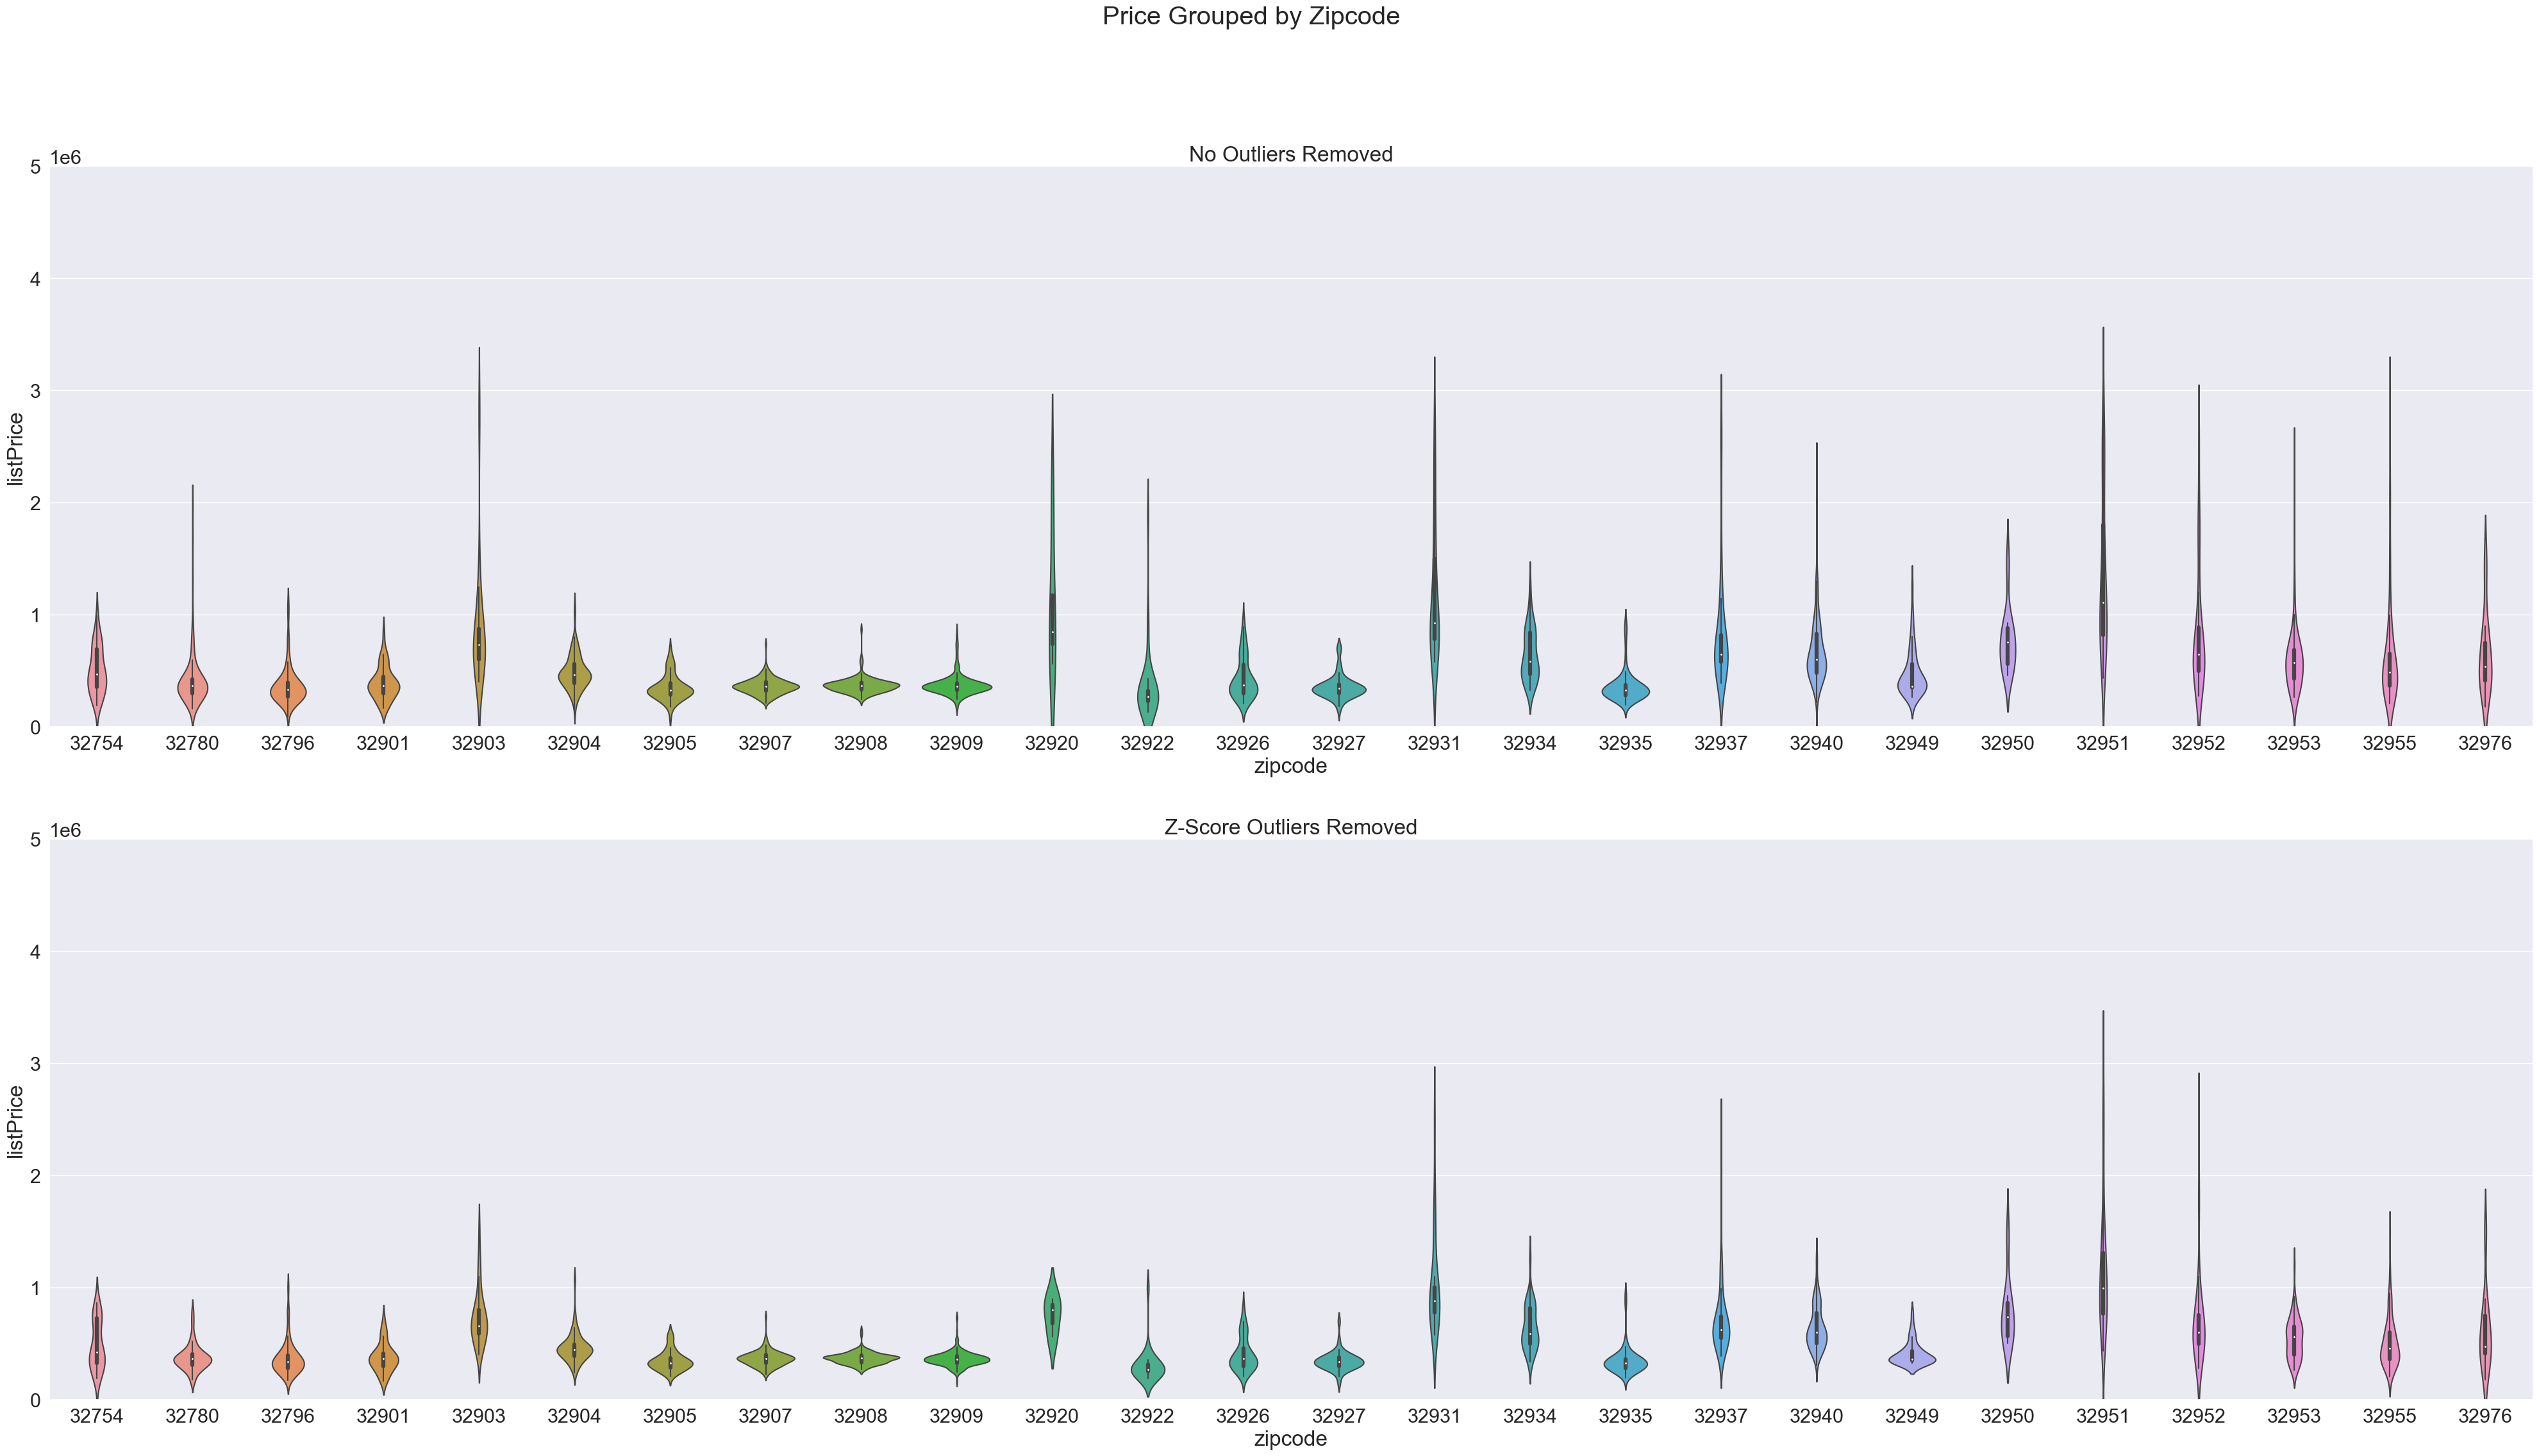

In [12]:
'''
Effect of Z-score outlier detection on price per zipcode during data wrangling
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))
sns.set_theme(font_scale=2.0)
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
plt.suptitle('Price Grouped by Zipcode')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale, ax=ax[0])
ax[0].title.set_text('No Outliers Removed')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale.loc[df_forSale['Outlier: Z-Score']==0], ax=ax[1])
ax[1].title.set_text('Z-Score Outliers Removed')

plt.show()

And finally, here you can see that using a Z-score outlier detection the results look noticeably more promising. This uses a 1sigma inclusion criterion; this is only representative of ~68% of the data.

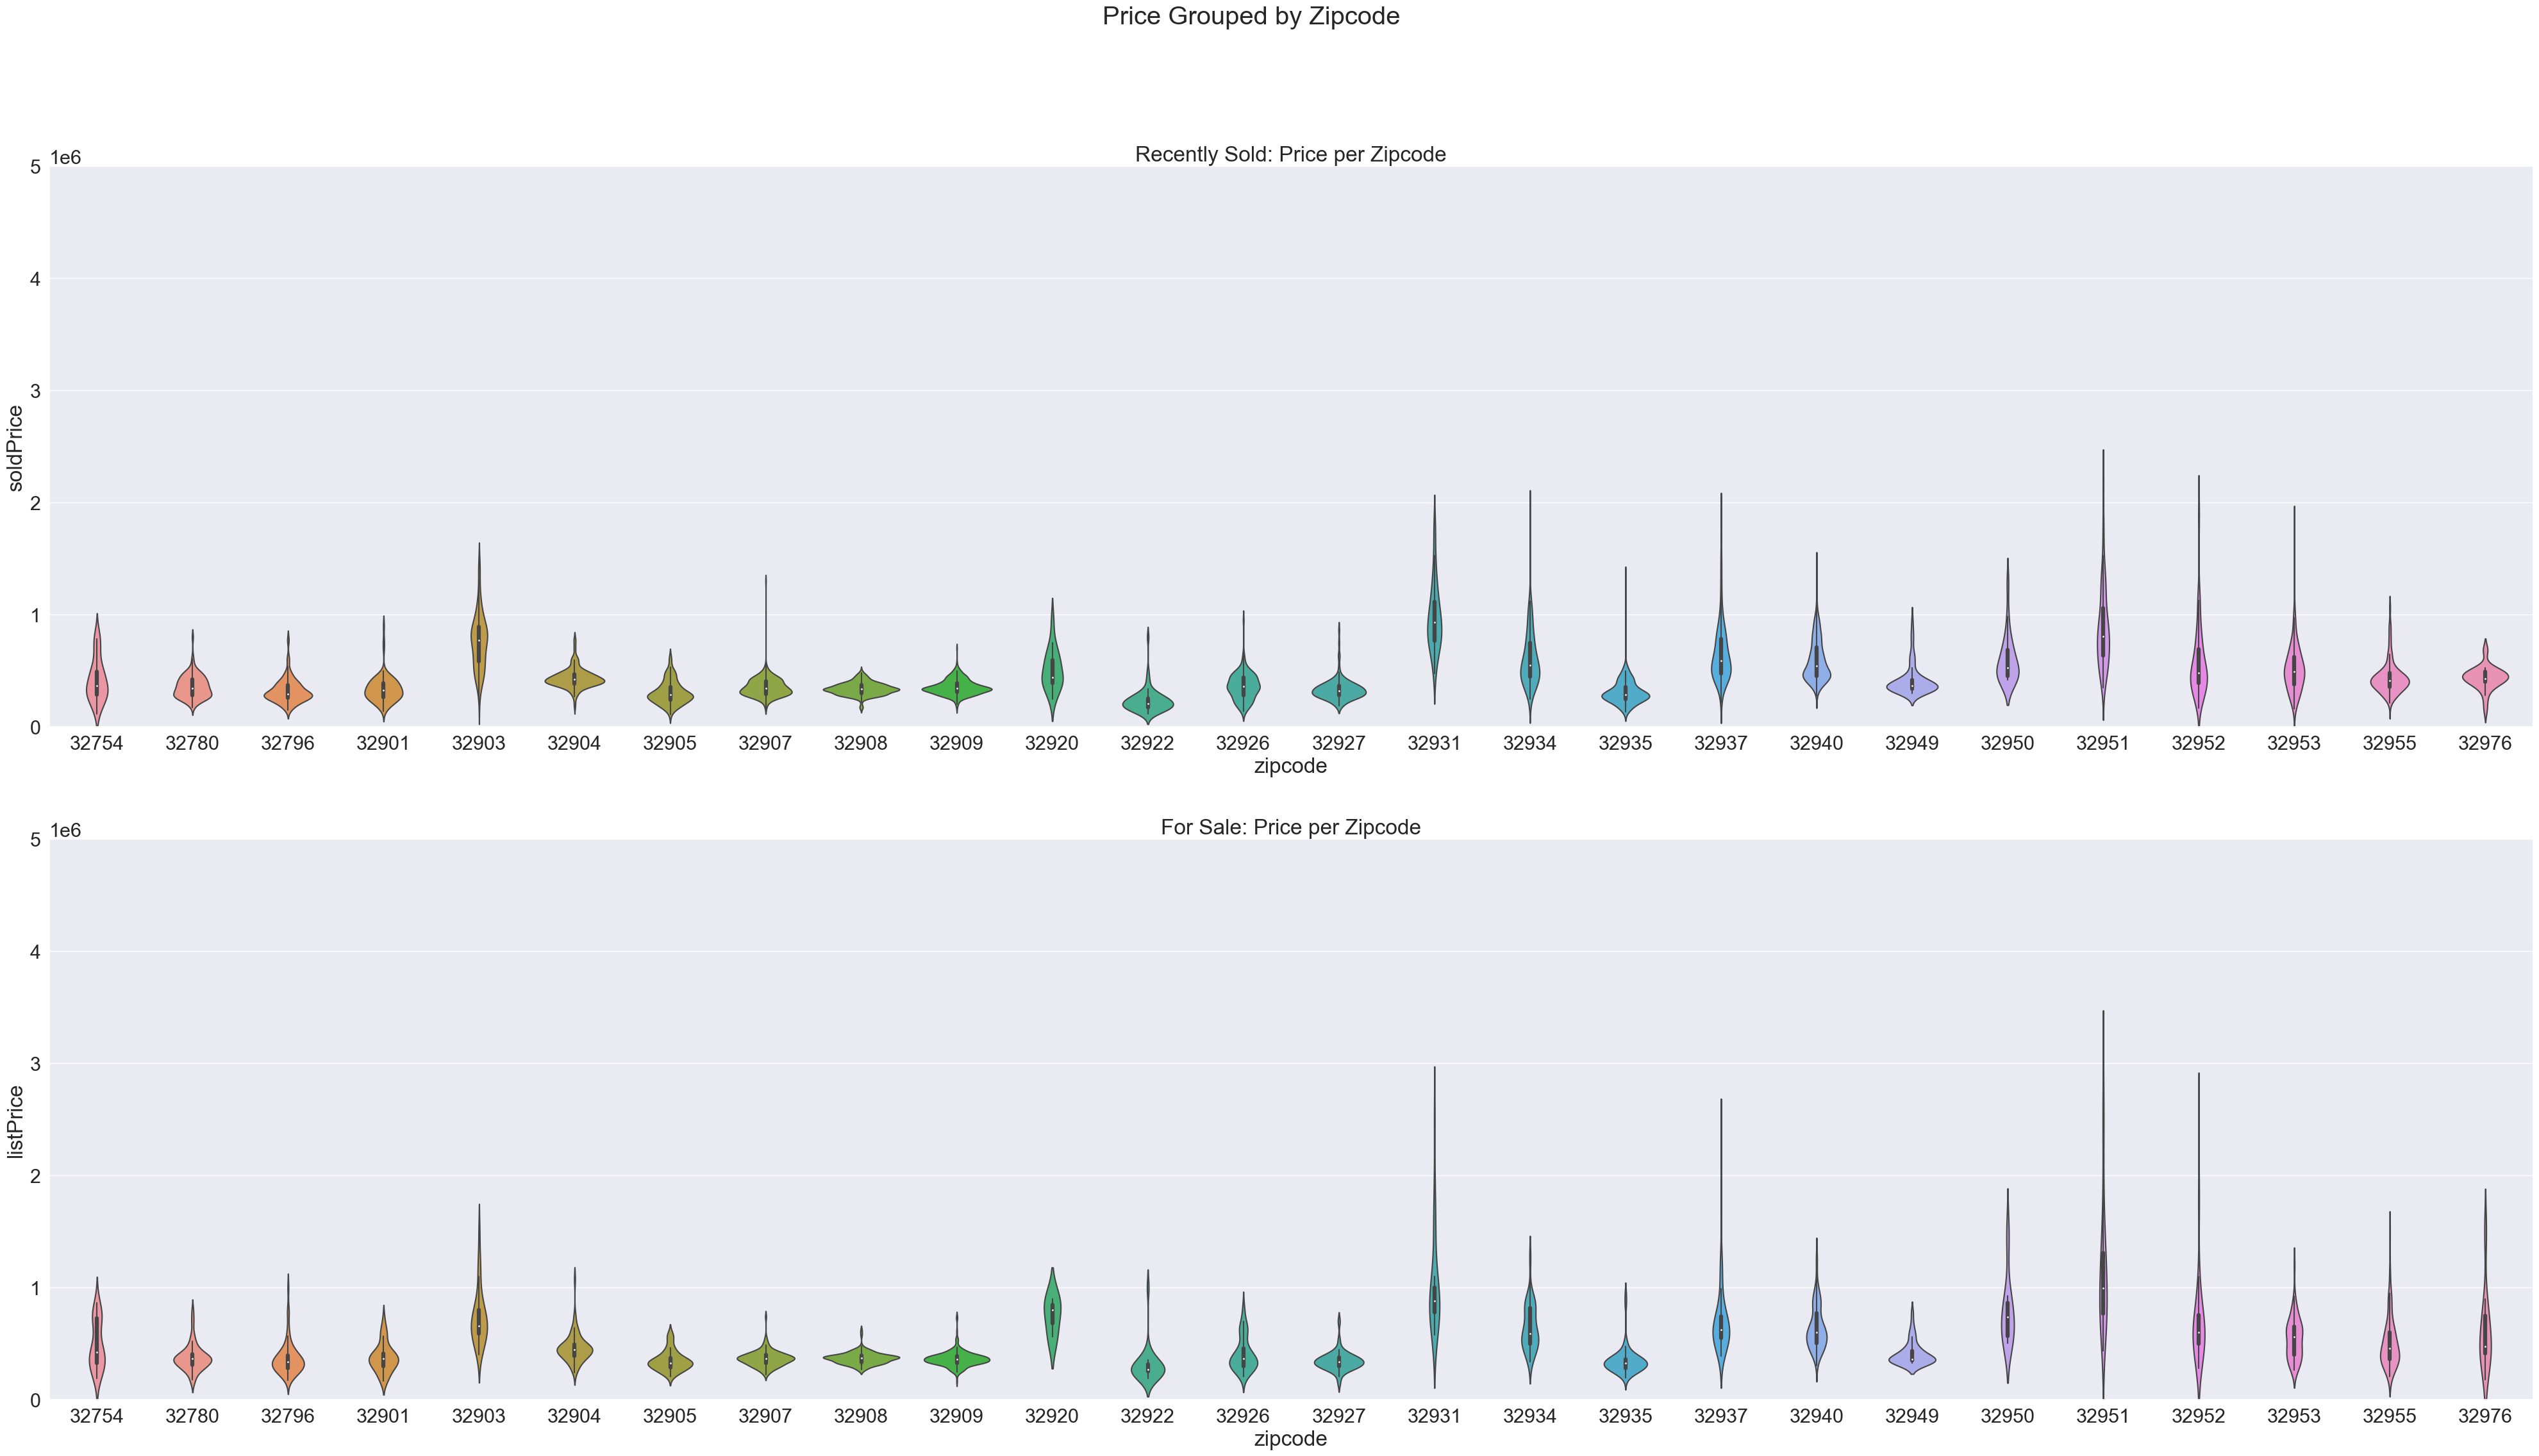

In [13]:
'''
Price distribution by zipcode - Initial outliers removed.
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))
sns.set_theme(font_scale=2.0)
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
plt.suptitle('Price Grouped by Zipcode')

sns.violinplot(x='zipcode', y='soldPrice', data=df_recentlySold.loc[df_recentlySold['Outlier: Z-Score']==0], ax=ax[0])
ax[0].title.set_text('Recently Sold: Price per Zipcode')

sns.violinplot(x='zipcode', y='listPrice', data=df_forSale.loc[df_forSale['Outlier: Z-Score']==0], ax=ax[1])
ax[1].title.set_text('For Sale: Price per Zipcode')

plt.show()

In [14]:
'''
Checking feature distribution similarities using two-sample Kolmogorov-Smirnov fit of goodness after removing Z-score price outliers.
'''

yes = 0
no = 0
diff_Feats = []

print('ATTENTION: Make sure the two dataframes have the same number of features and are in the same order!')
print('')

data_fs = df_forSale.loc[df_forSale['Outlier: Z-Score']==0].shape[1]
data_rs = df_recentlySold.loc[df_recentlySold['Outlier: Z-Score']==0].shape[1]
for i in range(data_fs):
    # Assuming 'data1' and 'data2' are your datasets
    statistic, p_value = ks_2samp(df_forSale.loc[df_forSale['Outlier: Z-Score']==0].iloc[:, i].values, df_recentlySold.loc[df_recentlySold['Outlier: Z-Score']==0].iloc[:, i].values)
    if p_value < 0.05:
        # print(f'Feature {df_forSale.columns[i]} is significantly different.')
        diff_Feats.append(df_forSale.loc[df_forSale['Outlier: Z-Score']==0].columns[i])
        yes+=1
    else:
        # print(f'Feature {df_forSale.columns[i]} is NOT significantly different')
        no+=1

print(f'{yes} of {yes+no} ({round(yes/(yes+no)*100,2)}%) feature distributions are significantly different.')
if round(yes/(yes+no)*100,2) > 5:
    print('Recommend distribution matching!')
print('')
print(f'These are the features that differ:')
for feat in diff_Feats:
    print(feat)

ATTENTION: Make sure the two dataframes have the same number of features and are in the same order!

14 of 156 (8.97%) feature distributions are significantly different.
Recommend distribution matching!

These are the features that differ:
zipcode
yearBuilt
price/sqft
latitude
zestimate
resoFacts.taxAnnualAmount
daysOnZillow
schoolMaxRating
longitude
cityId_53787
yearBuilt_2023
yearBuilt_2024
zipcode_32909
listPrice


Based on the little improvement found here, setting the two dataframe distributions to be equivalent will be necessary prior to model training.

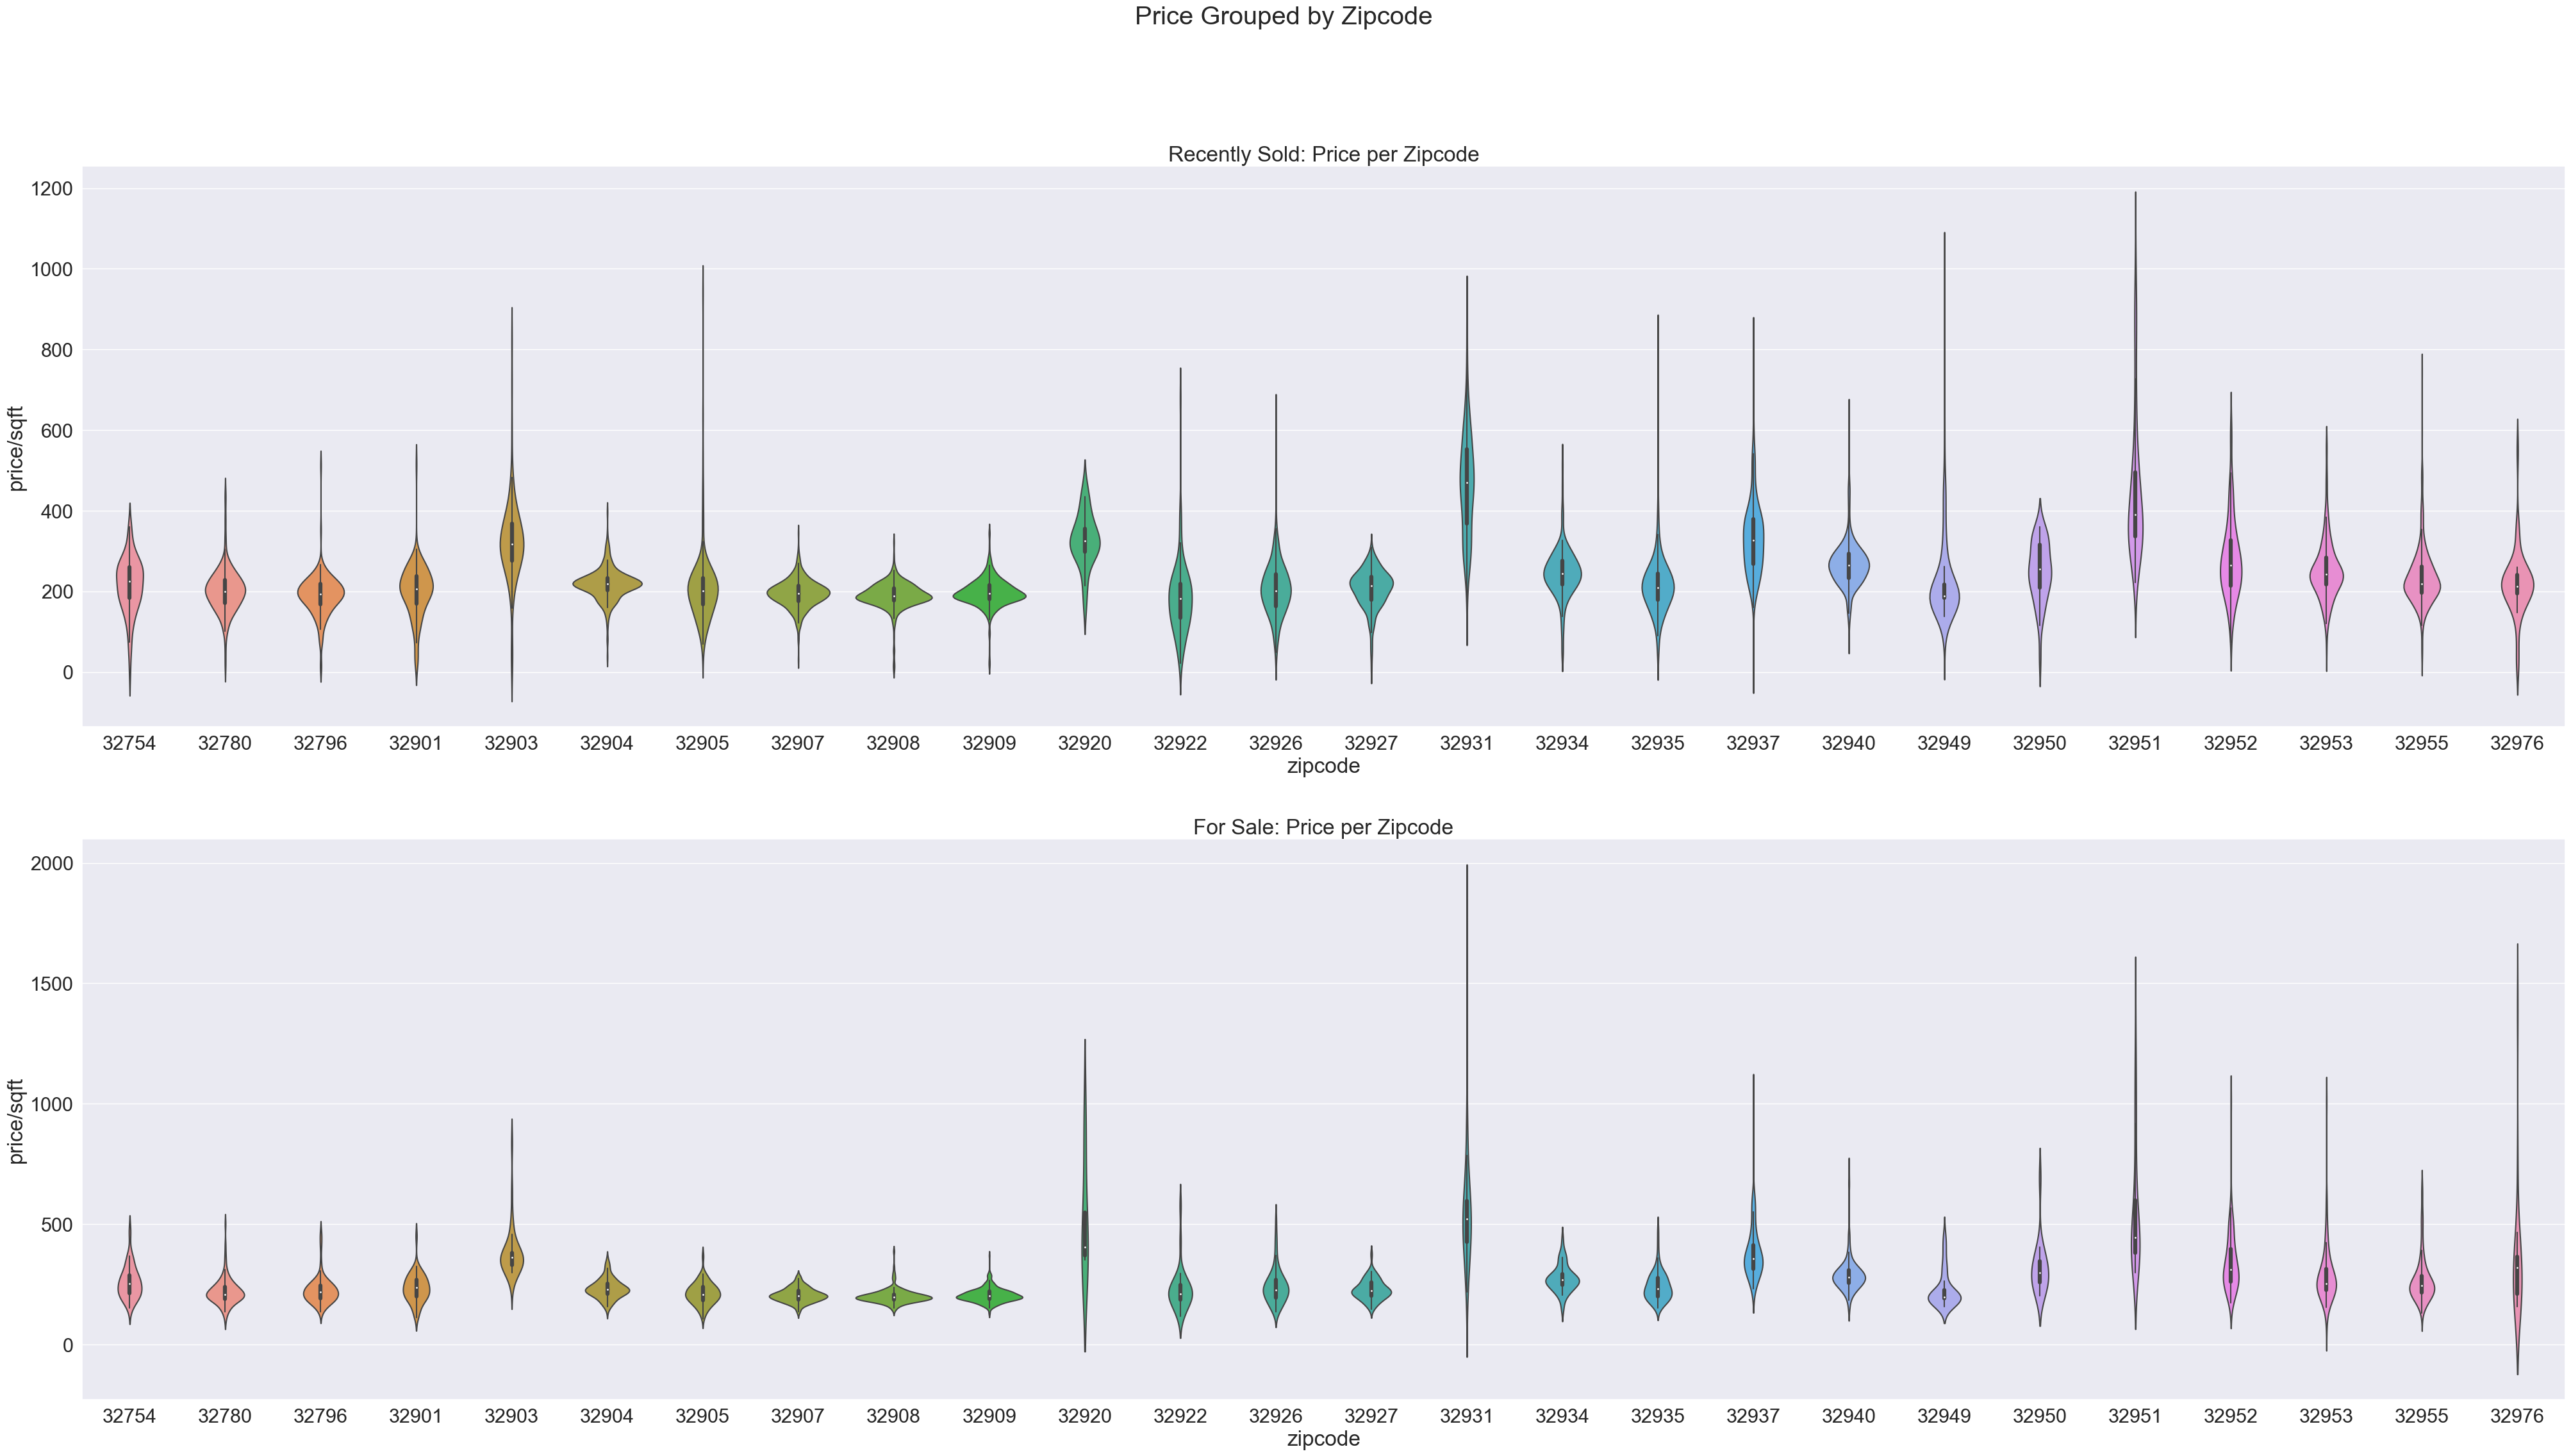

In [15]:
'''
Other distribution by zipcode - No outliers removed.
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))
sns.set_theme(font_scale=2.0)
# plt.setp(ax[0], ylim=[0, 2000])
# plt.setp(ax[1], ylim=[0, 2000])
plt.suptitle('Price Grouped by Zipcode')

sns.violinplot(x='zipcode', y='price/sqft', data=df_recentlySold, ax=ax[0])
ax[0].title.set_text('Recently Sold: Price per Zipcode')

sns.violinplot(x='zipcode', y='price/sqft', data=df_forSale, ax=ax[1])
ax[1].title.set_text('For Sale: Price per Zipcode')

plt.show()

# Feature Investigation

---

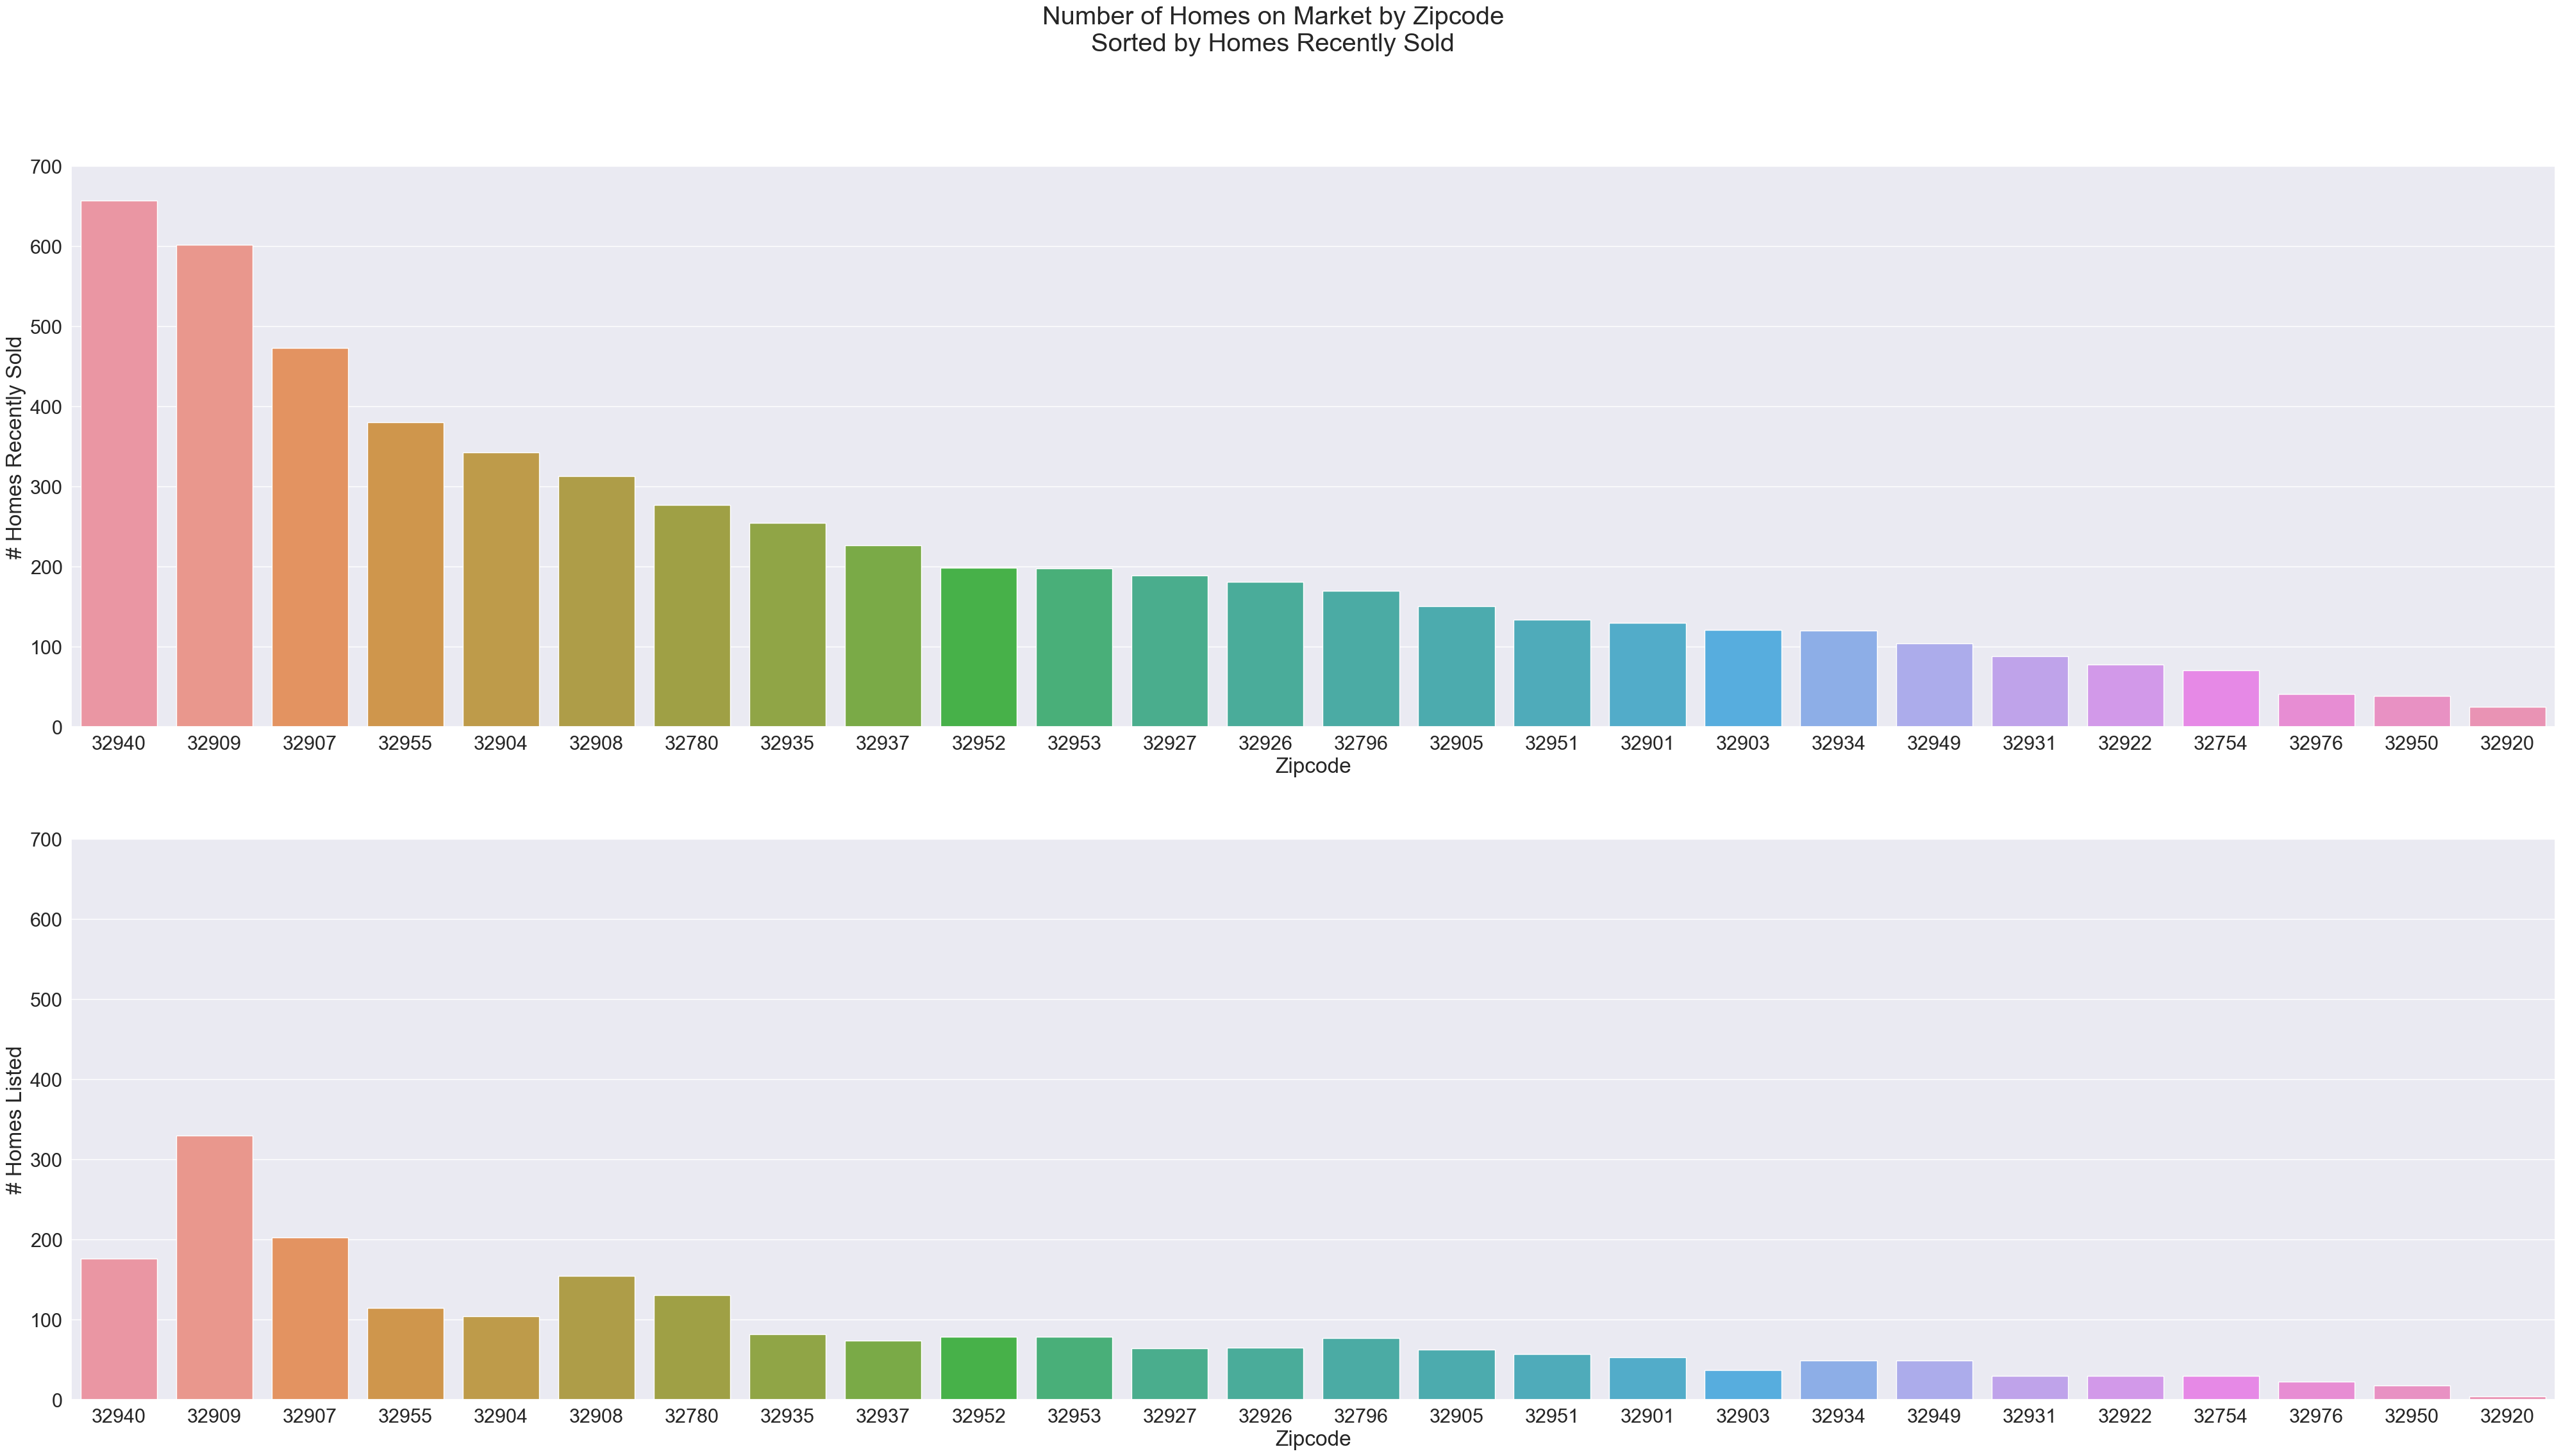

In [16]:
'''
Bar chart of number of homes sold/for sale by zipcode, sorted
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))

data_fs = df_forSale['yearBuilt'].groupby(df_forSale['zipcode']).count().reset_index()
data_rs = df_recentlySold['yearBuilt'].groupby(df_recentlySold['zipcode']).count().reset_index()
data = pd.merge(data_fs, data_rs, on='zipcode')

data.sort_values(by='yearBuilt_y', ascending=False, inplace=True)
data.reset_index(inplace=True)
data['zipcode'] = data['zipcode'].apply(str)

sns.barplot(data=data, x=data['zipcode'], y=data['yearBuilt_y'], ax=ax[0])
ax[0].set(xlabel='Zipcode', ylabel='# Homes Recently Sold', ylim=[0, 700])

sns.barplot(data=data, x=data['zipcode'], y=data['yearBuilt_x'], ax=ax[1])
ax[1].set(xlabel='Zipcode', ylabel='# Homes Listed', ylim=[0, 700])
plt.suptitle('Number of Homes on Market by Zipcode\nSorted by Homes Recently Sold')

plt.show()

del data

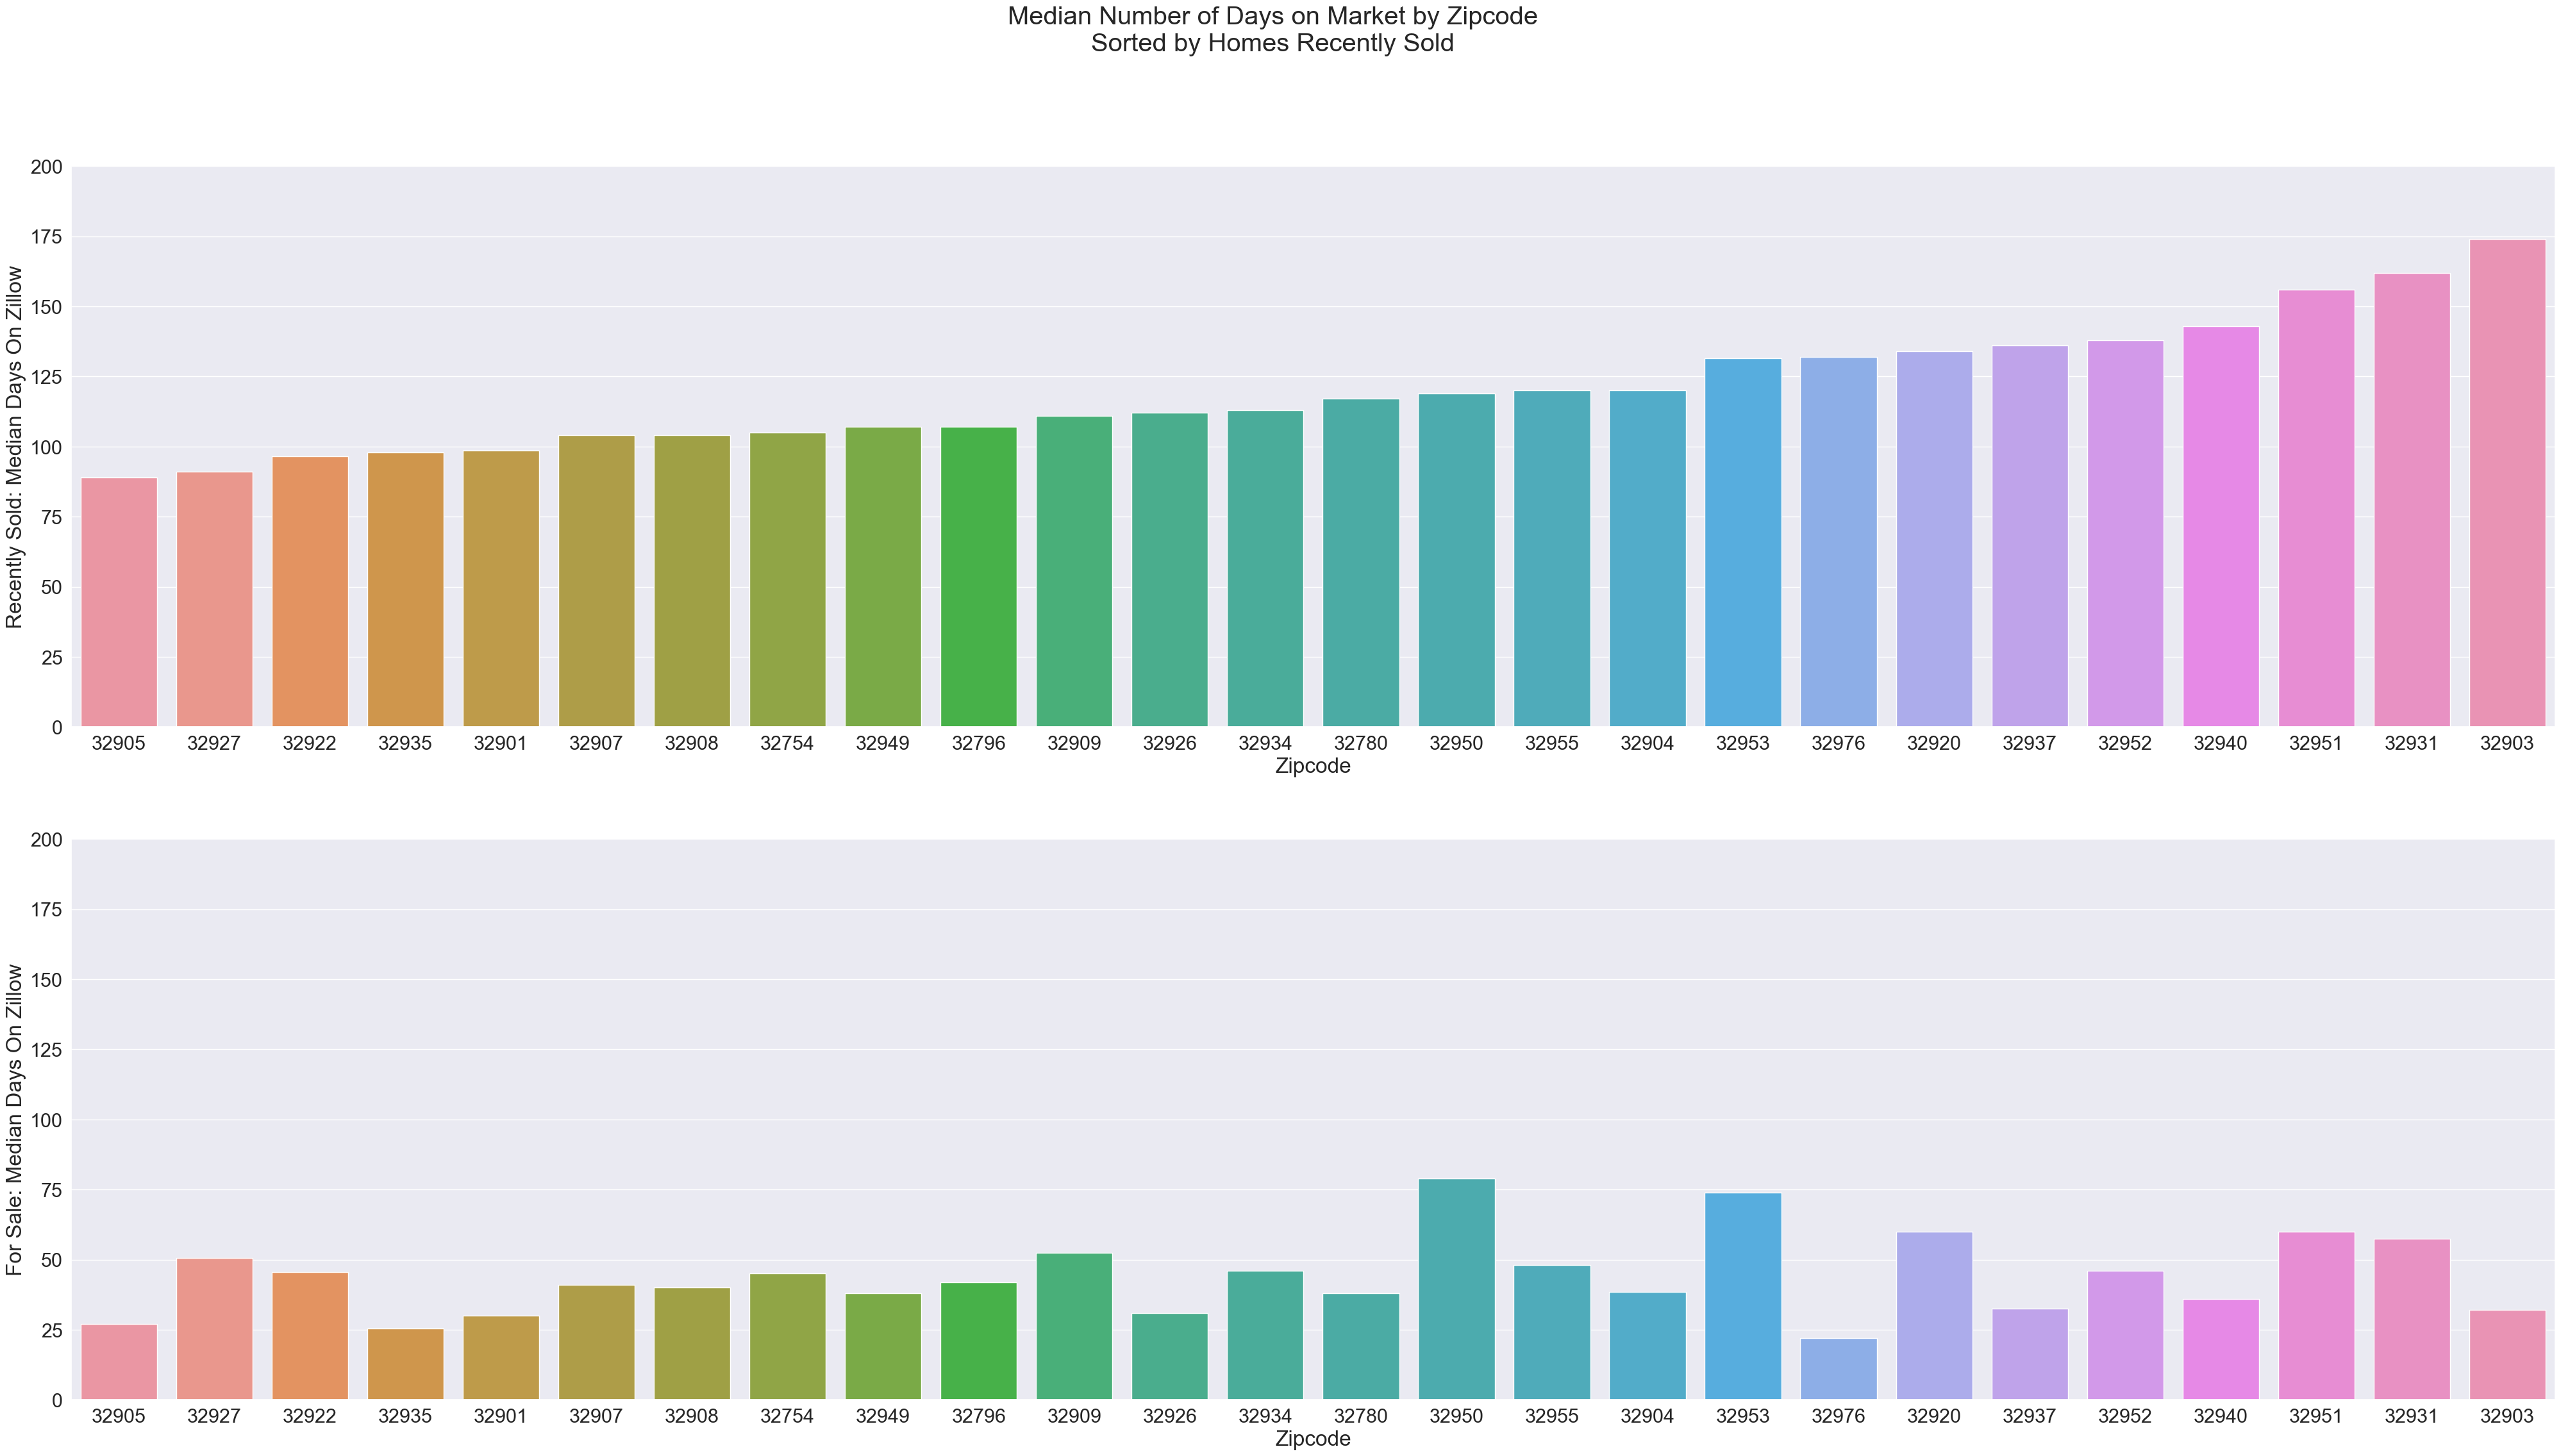

In [17]:
'''
Bar chart of average days on Zillow by zipcode, sorted
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))

data_fs = df_forSale['daysOnZillow'].groupby(df_forSale['zipcode']).median().reset_index()
data_rs = df_recentlySold['daysOnZillow'].groupby(df_recentlySold['zipcode']).median().reset_index()
data = pd.merge(data_fs, data_rs, on='zipcode')

data.sort_values(by='daysOnZillow_y', ascending=True, inplace=True)
data.reset_index(inplace=True)
data['zipcode'] = data['zipcode'].apply(str)

sns.barplot(data=data, x=data['zipcode'], y=data['daysOnZillow_y'], ax=ax[0])
ax[0].set(xlabel='Zipcode', ylabel='Recently Sold: Median Days On Zillow', ylim=[0, 200])

sns.barplot(data=data, x=data['zipcode'], y=data['daysOnZillow_x'], ax=ax[1])
ax[1].set(xlabel='Zipcode', ylabel='For Sale: Median Days On Zillow', ylim=[0, 200])
plt.suptitle('Median Number of Days on Market by Zipcode\nSorted by Homes Recently Sold')

plt.show()

del data

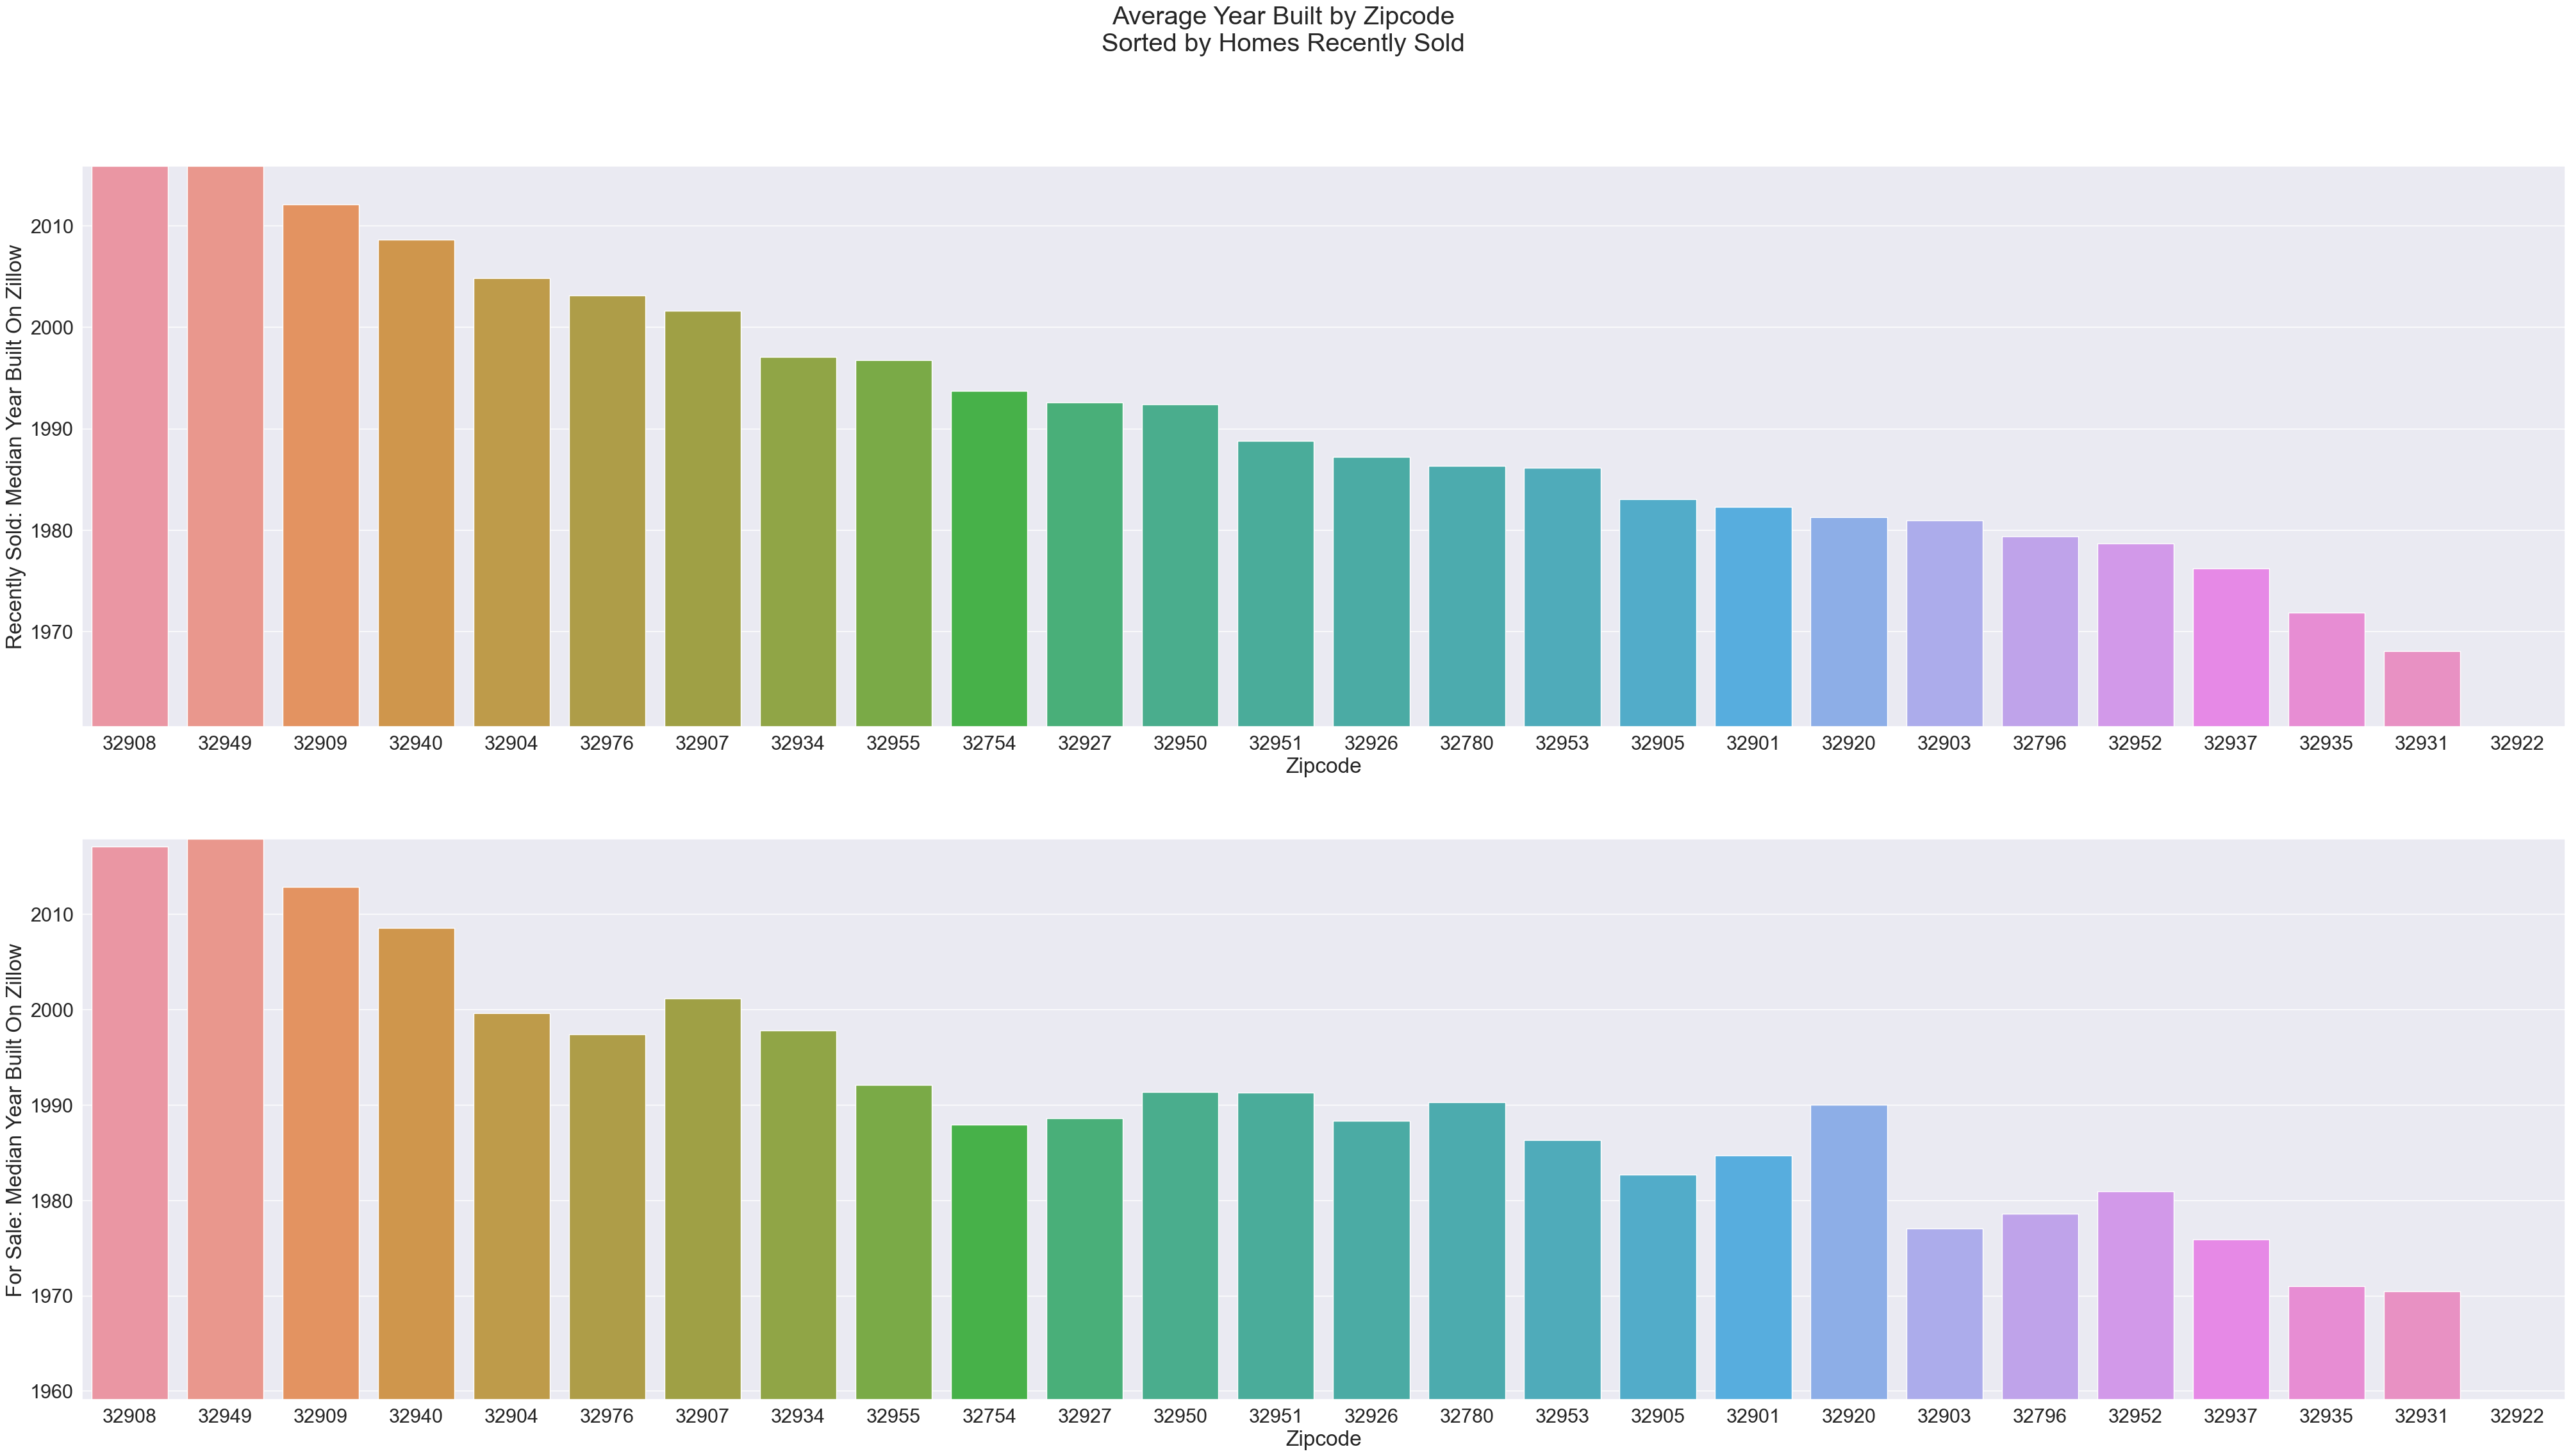

In [18]:
'''
Bar chart of average home year built on Zillow by zipcode, sorted
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))

data_fs = df_forSale['yearBuilt'].groupby(df_forSale['zipcode']).mean().reset_index()
data_rs = df_recentlySold['yearBuilt'].groupby(df_recentlySold['zipcode']).mean().reset_index()
data = pd.merge(data_fs, data_rs, on='zipcode')

data.sort_values(by='yearBuilt_y', ascending=False, inplace=True)
data.reset_index(inplace=True)
data['zipcode'] = data['zipcode'].apply(str)

sns.barplot(data=data, x=data['zipcode'], y=data['yearBuilt_y'], ax=ax[0])
ax[0].set(xlabel='Zipcode', ylabel='Recently Sold: Median Year Built On Zillow', ylim=[data['yearBuilt_y'].min(), data['yearBuilt_y'].max()])

sns.barplot(data=data, x=data['zipcode'], y=data['yearBuilt_x'], ax=ax[1])
ax[1].set(xlabel='Zipcode', ylabel='For Sale: Median Year Built On Zillow', ylim=[data['yearBuilt_x'].min(), data['yearBuilt_x'].max()])
plt.suptitle('Average Year Built by Zipcode\nSorted by Homes Recently Sold')

plt.show()

del data

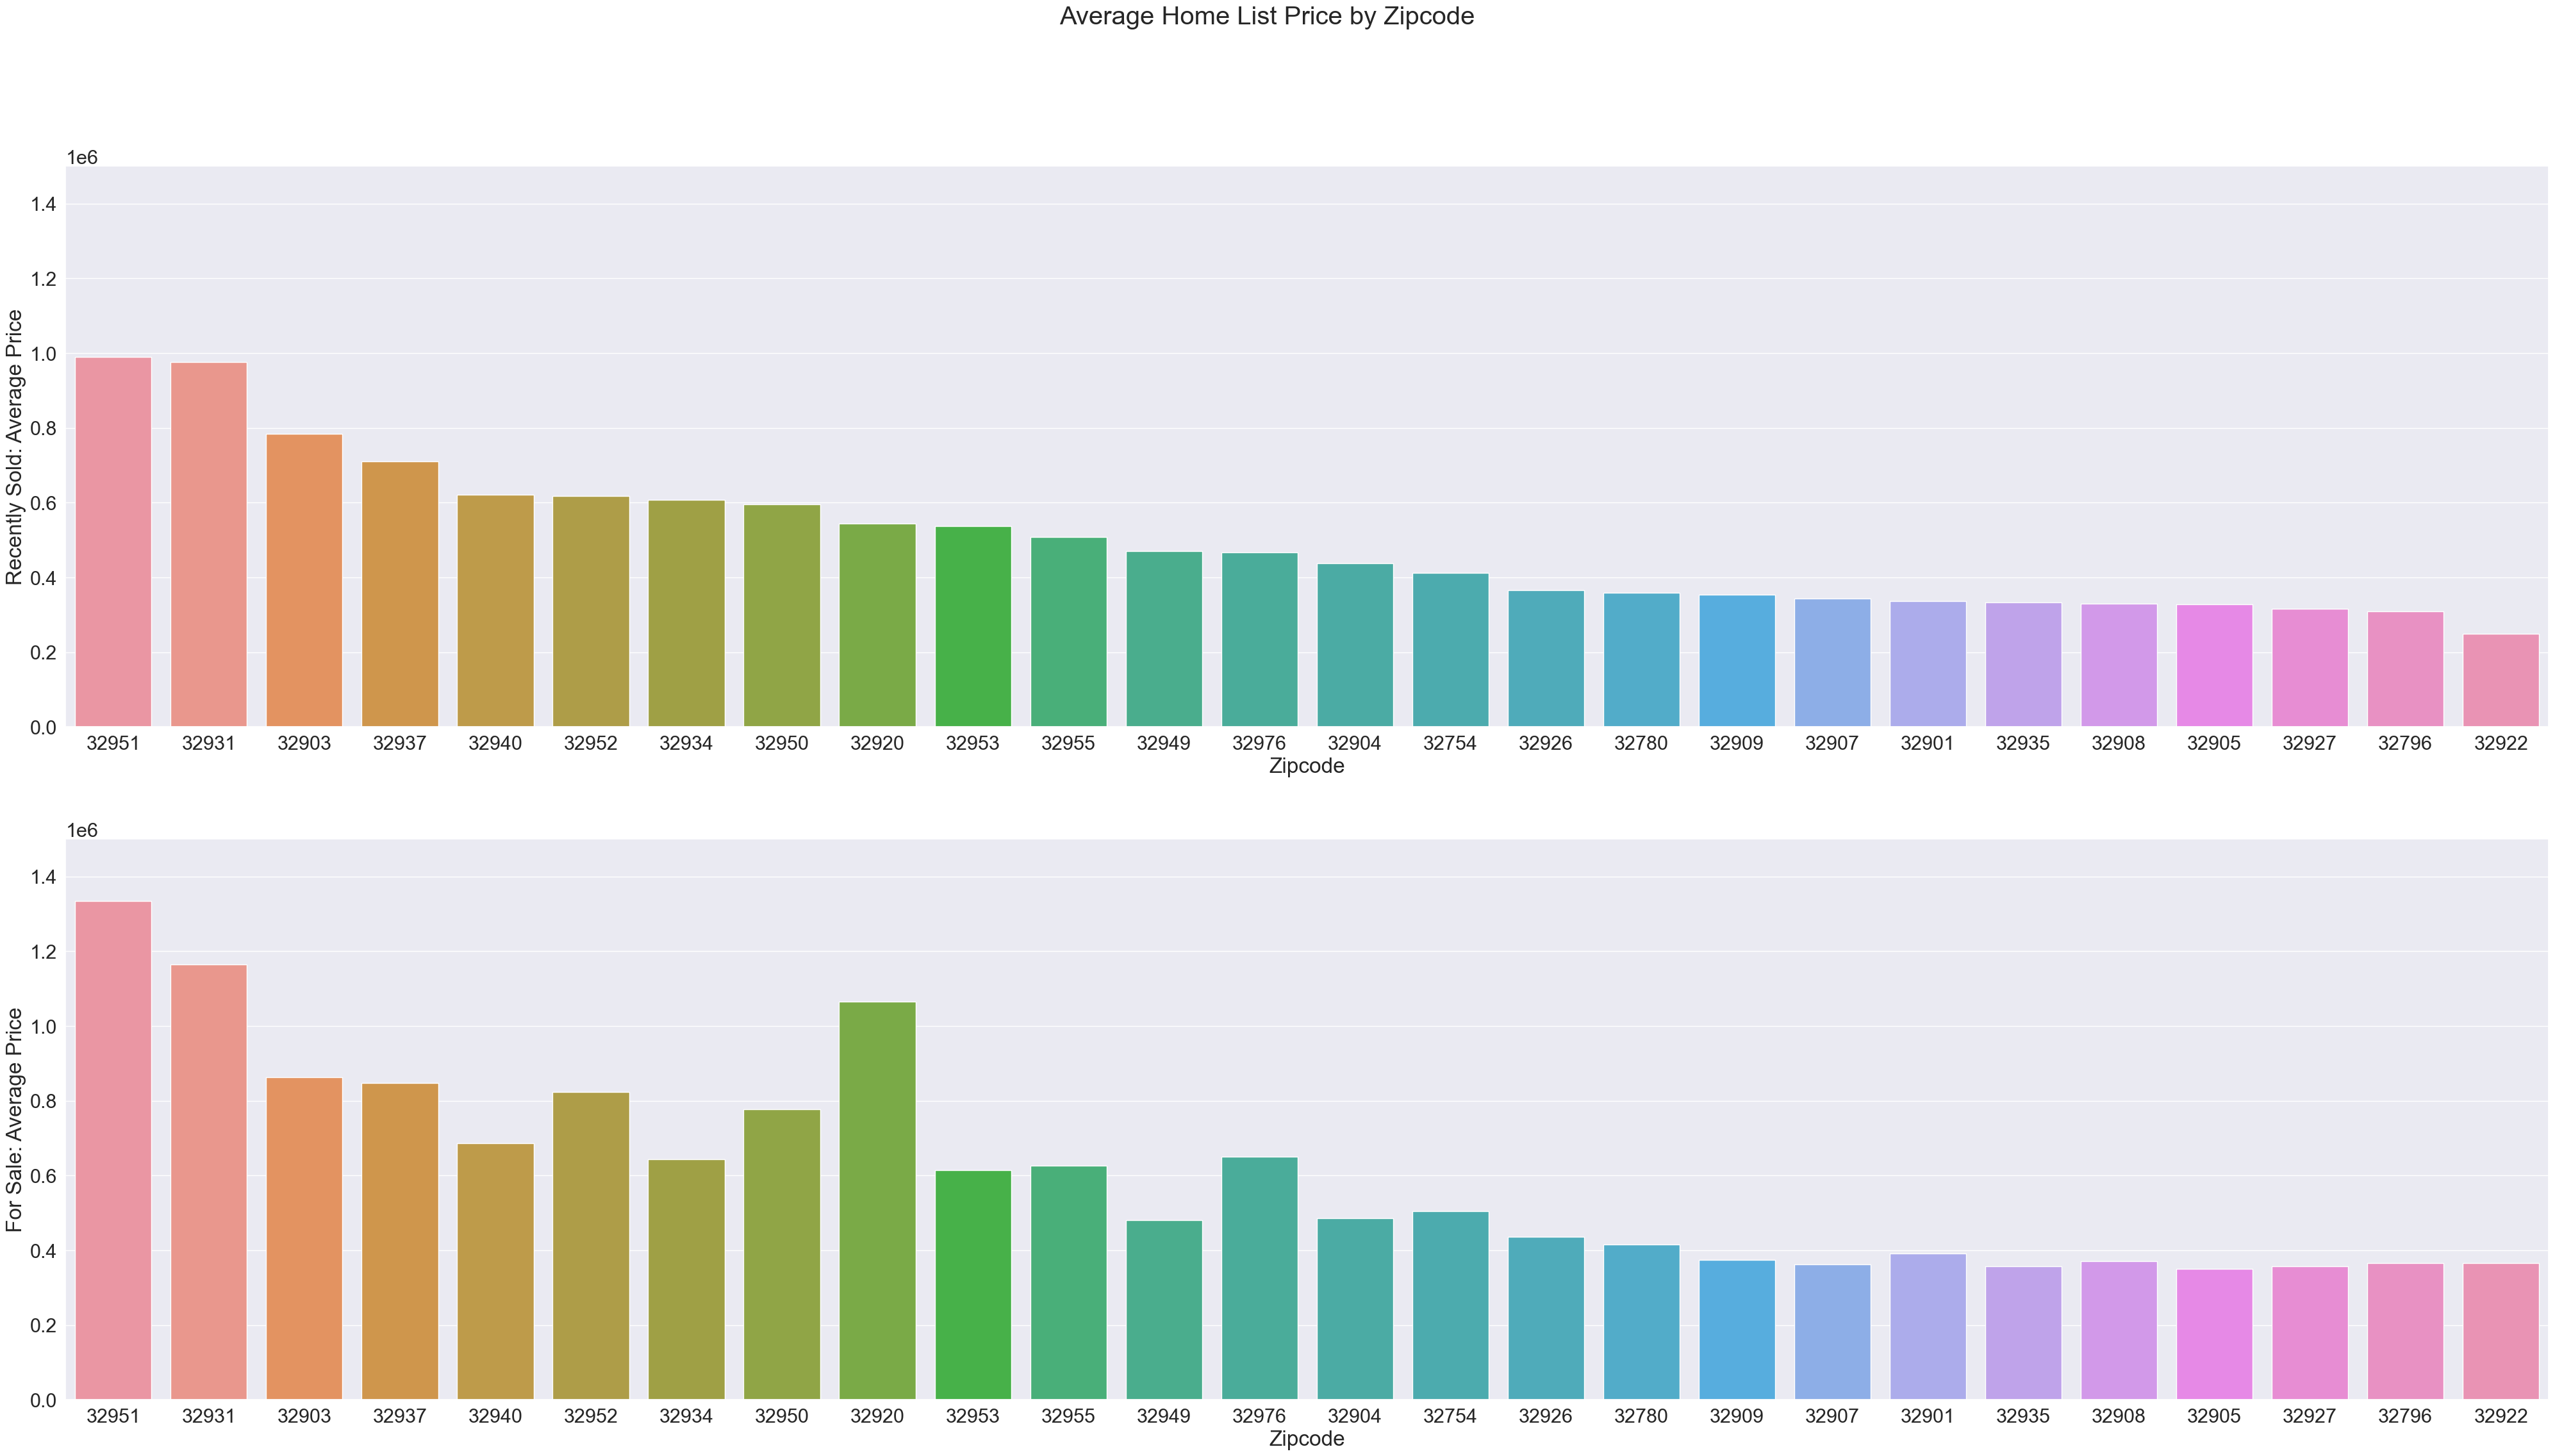

In [19]:
'''
Bar chart of average list price by zipcode, sorted
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))

data_fs = df_forSale['listPrice'].groupby(df_forSale['zipcode']).mean().reset_index()
data_rs = df_recentlySold['soldPrice'].groupby(df_recentlySold['zipcode']).mean().reset_index()
data = pd.merge(data_fs, data_rs, on='zipcode')

data.sort_values(by='soldPrice', ascending=False, inplace=True)
data.reset_index(inplace=True)
data['zipcode'] = data['zipcode'].apply(str)

sns.barplot(data=data, x=data['zipcode'], y=data['soldPrice'], ax=ax[0])
ax[0].set(xlabel='Zipcode', ylabel='Recently Sold: Average Price', ylim=[0, 1.5e6])

sns.barplot(data=data, x=data['zipcode'], y=data['listPrice'], ax=ax[1])
ax[1].set(xlabel='Zipcode', ylabel='For Sale: Average Price', ylim=[0, 1.5e6])
plt.suptitle('Average Home List Price by Zipcode')

plt.show()

del data

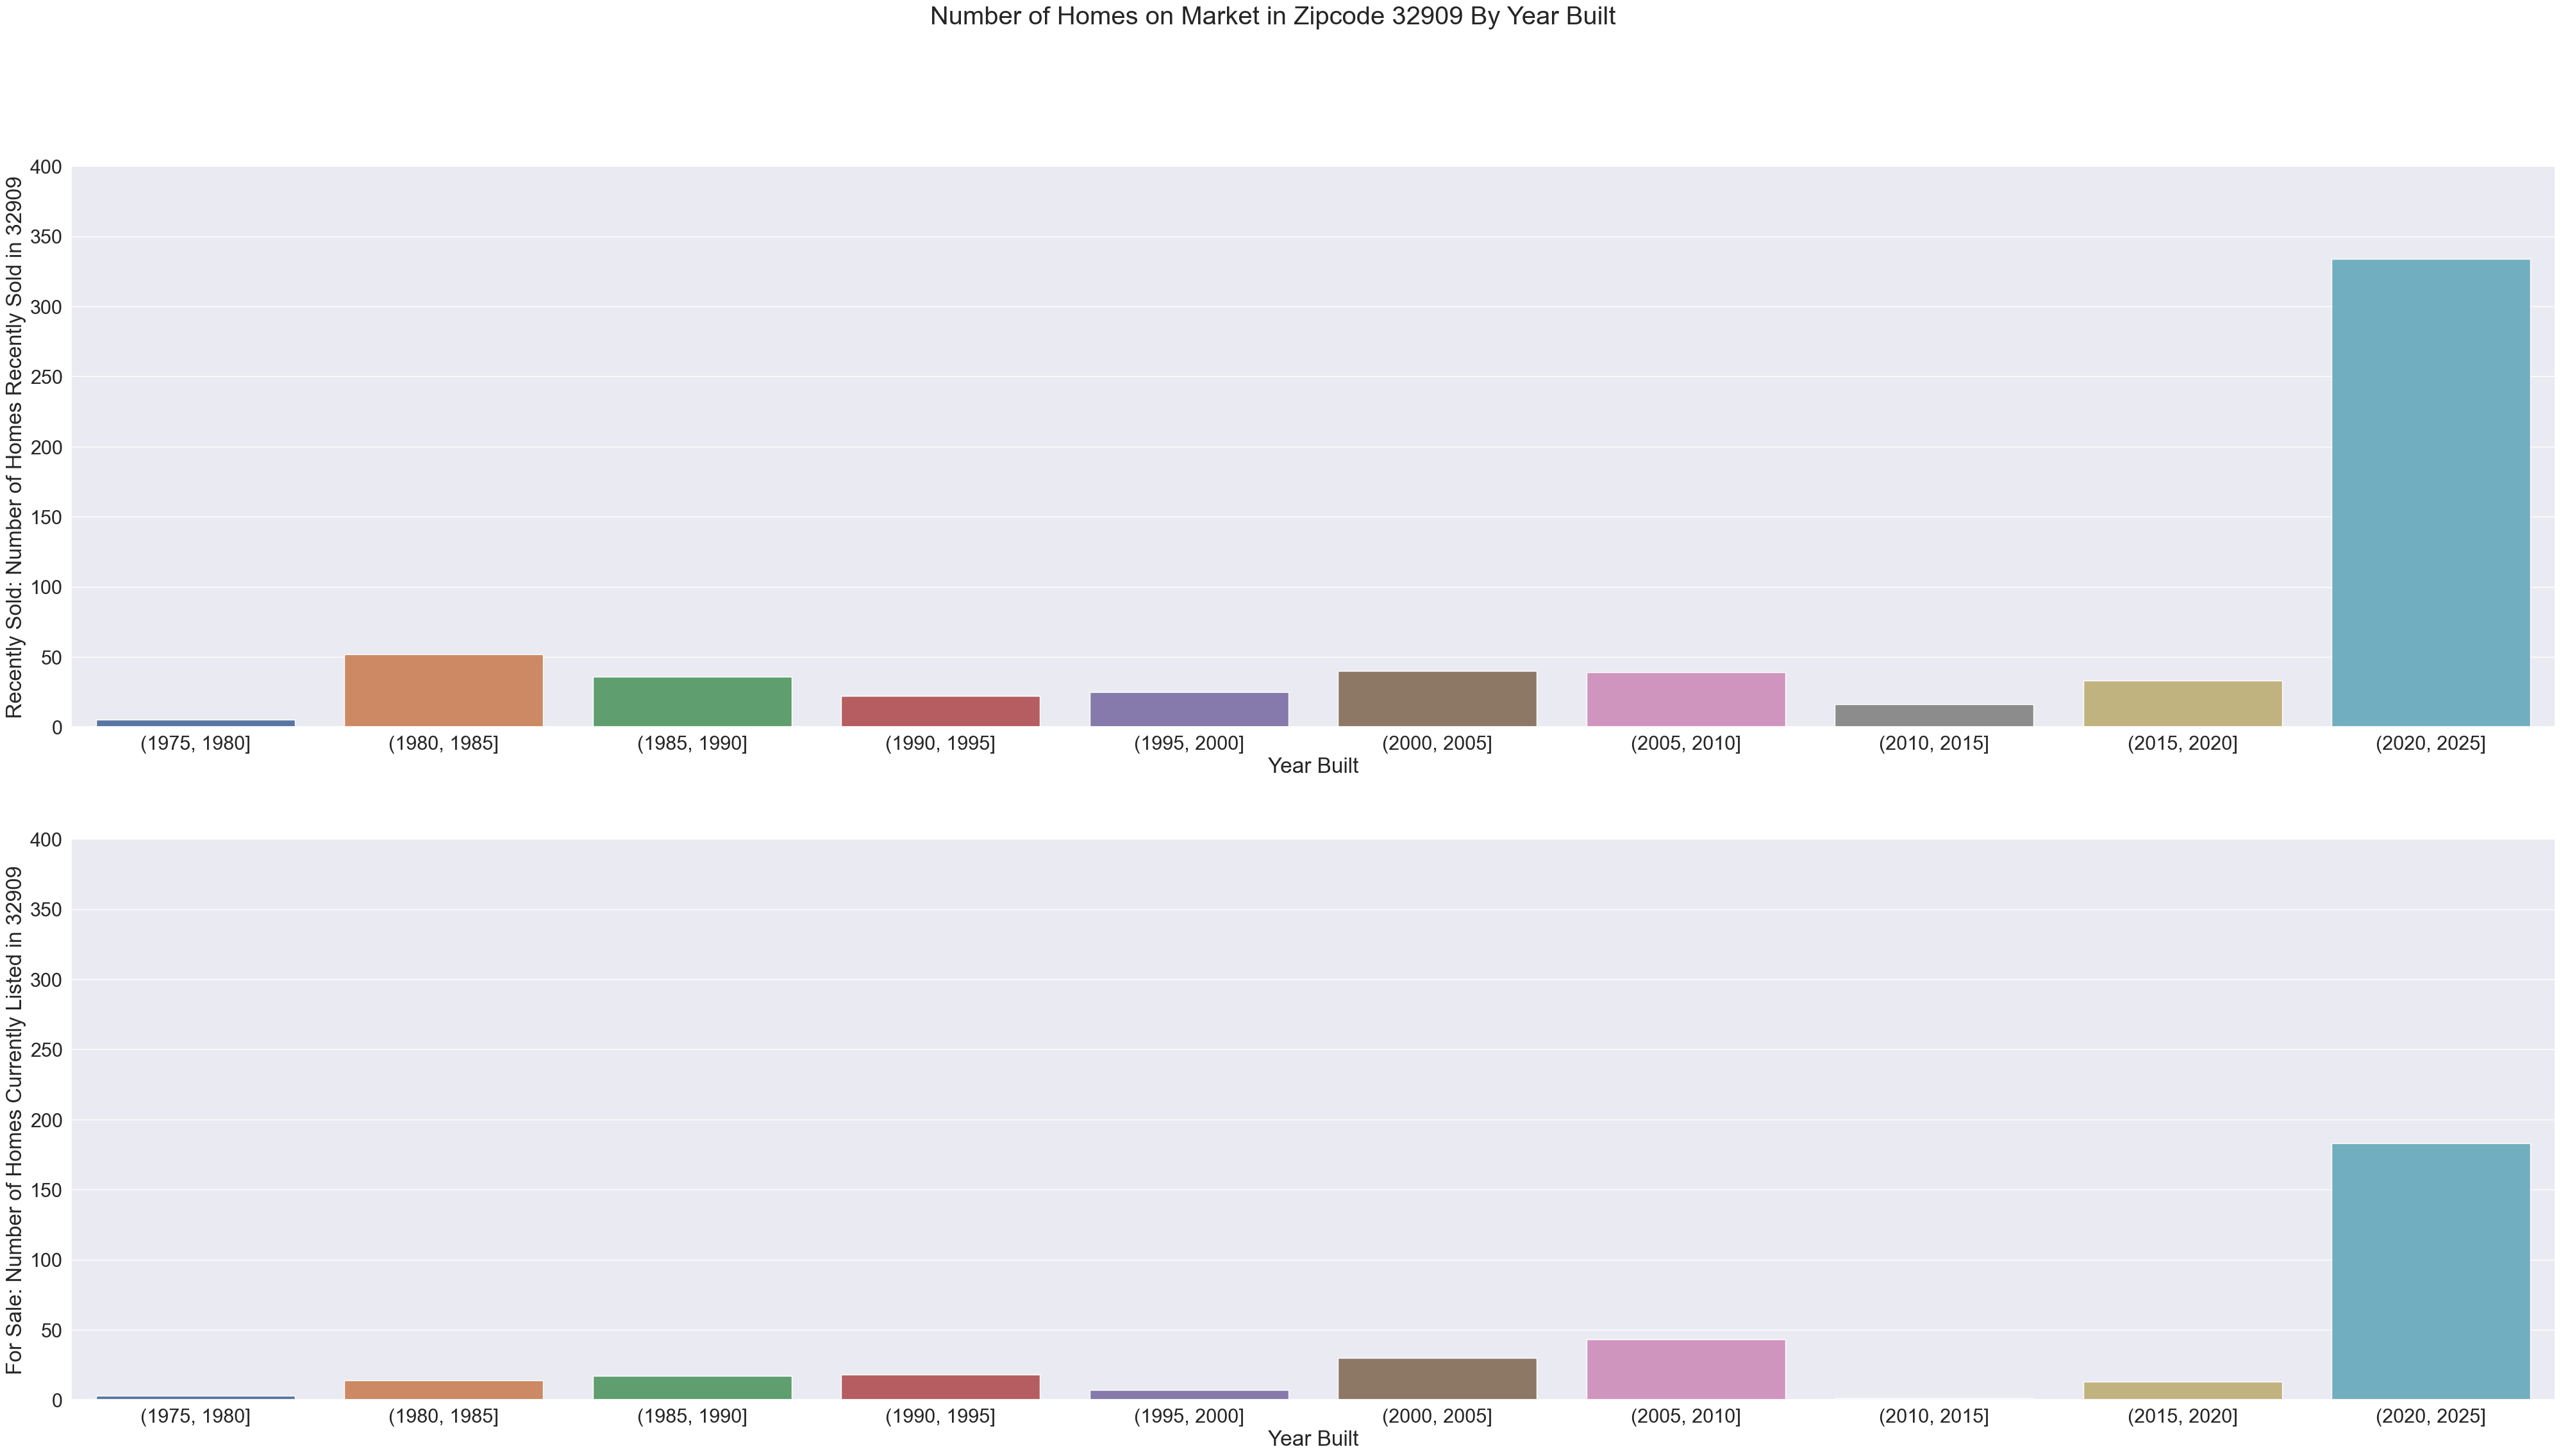

In [20]:
'''
Number of homes listed grouped by age for a specfic zipcode.
'''

fig, ax = plt.subplots(2,1,figsize =(50, 25))

zipcode = 32909

data_fs = df_forSale['listPrice'].loc[df_forSale['zipcode']==zipcode].groupby(pd.cut(df_forSale['yearBuilt'], list(range(1975, 2026, 5)))).count().reset_index()
data_rs = df_recentlySold['soldPrice'].loc[df_recentlySold['zipcode']==zipcode].groupby(pd.cut(df_recentlySold['yearBuilt'], list(range(1975, 2026, 5)))).count().reset_index()
data = pd.merge(data_fs, data_rs, on='yearBuilt')

data.sort_values(by='soldPrice', ascending=False, inplace=True)
data.reset_index(inplace=True)
data['yearBuilt'] = data['yearBuilt'].apply(str)

sns.barplot(data=data, x=data['yearBuilt'], y=data['soldPrice'], ax=ax[0])
ax[0].set(xlabel='Year Built', ylabel=f'Recently Sold: Number of Homes Recently Sold in {zipcode}', ylim=[0, 400])

sns.barplot(data=data, x=data['yearBuilt'], y=data['listPrice'], ax=ax[1])
ax[1].set(xlabel='Year Built', ylabel=f'For Sale: Number of Homes Currently Listed in {zipcode}', ylim=[0, 400])
plt.suptitle(f'Number of Homes on Market in Zipcode {zipcode} By Year Built')

plt.show()

del data

---
End of section.
## <pre><-- Previous: Data Wrangling                                       Next: Data Prediction --></pre>